# Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import scipy.stats as stats
from scipy.stats import chi2_contingency

from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, recall_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint

from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

import pickle

# Loading data

This dataset contains credit card offer acceptance information for customers of a bank.

Source of the data:  https://data.world/gautam2510/credit-card-dataset

# Description of the database "creditcardmarketing-bbm.csv"

### The independent variables recorded for these clients are as follows:

Customer Number: Unique identifier for each customer. (Integer)    

Reward: The type of reward offered with the credit card. (String)  

Mailer Type: The type of mailer used to send the offer. (String)  

Income Level: The customer’s income level. (String)  

#Bank Accounts Open: How many bank accounts does a customer have open? (Integer)  

Overdraft Protection: Whether or not a customer has overdraft protection on their account(s). (Boolean)  

Credit Rating: A rating based on how well a customer's payment record reflects their ability and willingness to repay debt under terms accepted by creditors. (String) 

#Credit Cards Held: How many credit cards does this user currently hold? (Integer)  

#Homes Owned: How many homes does this user own? (Integer)  

Household Size: Size of household that this person belongs is kept track of. (Integer)  

Own Your Home: Whether or not a particular user owns their home. (Boolean)  

Average Balance: Average balance across all accounts. (Float)  

Q1 Balance: The customers balance in each quarter throughout an entire year. (Float)  

Q2 Balance: The customers balance in each quarter throughout an entire year. (Float)  

Q3 Balance: The customers balance in each quarter throughout an entire year. (Float)  

Q4 Balance: The customers balance in each quarter throughout an entire year. (Float) 

### The target variable is: 

Offer Accepted: Whether or not the customer accepted the offer. (Boolean)

In [2]:
# pd.set_option('display.max_row', 20)          #Permet d'afficher toutes les colonnes(17) quand on fait le df.dtypes
# pd.set_option('display.max_column', 20)       #Permet d'afficher toutes les colonnes(17) quand on fait le df.head()

In [3]:
bankdata = pd.read_csv('creditcardmarketing-bbm.csv')

In [4]:
bankdata.head()

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [5]:
# Create a mapping dictionary for target variable

mapping = {"Yes": 1, "No": 0}

# Apply the mapping to the column
bankdata['Offer_Accepted_binary'] = bankdata['Offer Accepted'].map(mapping)

# 1. Exploratory Data Analysis

## Objective :
- Understand our data as best as possible
- Develop a first modeling strategy 

## Basic checklist
#### Shape Analysis:
- **variable target**: Offer Accepted
- **rows and columns**: 18000, 17
- **types of variables**: qualitative: 7, quantitative: 10
- **Analysis of missing values**:
     - Very few missing values (less than 1%)

#### Background Analysis:
- **Visualization of the target**:
     - 6% Acceptance (1023 / 18000)
 
    
- **Meaning of variables**:
     - asymmetrical, non-standardized continuous variables
     - quantitative variables: larger households tend to accept the offer more (hypothesis to be verified)
     - qualitative variables: binary (0, 1) and ternary (0, 1, 2), many own a house, many do not have an overdraft, and many have an average salary.



- **Variables / Target relationship**:
     - target / continuous variables: there is no particular relationship between target variables and continuous variables
     - target/categorical variables: we can say that the type of reward (air mails, cash back), the mailer type (postcard) and a low credit rating improve the acceptance of the credit card offer. (Hypothesis a check)
     - target / discrete variables: those who have a lower bank balance tend to accept the offer (hypothesis to be verified)
    
    
    
## More detailed analysis

- **Relationship Variables / Variables**:
     - continuous variables / continuous variables: certain variables are moderately correlated: +0.5 (to be monitored later)
     - discrete variables / discrete variables: strongly correlated.
     - categorical variables / categorical variables: we observe that individuals are not divided, everyone is sure of the choice they make, and no one has to choose between one or more preferences, this could help us later to better classify individuals by categories.

- **NaN analysis**: there are 24 nan on the 18000 lines, and its 24 nan are on the last 24 lines of the float_columns variables

In [6]:
df = bankdata.copy()

In [7]:
# a. Shape of the data
print("Shape of the data:", df.shape)

# b. Data type of each attribute
print("\nData type of each attribute:")
df.info()

df.dtypes.value_counts()

Shape of the data: (18000, 18)

Data type of each attribute:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Customer Number        18000 non-null  int64  
 1   Offer Accepted         18000 non-null  object 
 2   Reward                 18000 non-null  object 
 3   Mailer Type            18000 non-null  object 
 4   Income Level           18000 non-null  object 
 5   # Bank Accounts Open   18000 non-null  int64  
 6   Overdraft Protection   18000 non-null  object 
 7   Credit Rating          18000 non-null  object 
 8   # Credit Cards Held    18000 non-null  int64  
 9   # Homes Owned          18000 non-null  int64  
 10  Household Size         18000 non-null  int64  
 11  Own Your Home          18000 non-null  object 
 12  Average Balance        17976 non-null  float64
 13  Q1 Balance             17976 non-null  float6

object     7
int64      6
float64    5
Name: count, dtype: int64

In [8]:
# c. Checking the presence of missing values
print("\nChecking the presence of missing values:")
print(df.isnull().sum())


Checking the presence of missing values:
Customer Number           0
Offer Accepted            0
Reward                    0
Mailer Type               0
Income Level              0
# Bank Accounts Open      0
Overdraft Protection      0
Credit Rating             0
# Credit Cards Held       0
# Homes Owned             0
Household Size            0
Own Your Home             0
Average Balance          24
Q1 Balance               24
Q2 Balance               24
Q3 Balance               24
Q4 Balance               24
Offer_Accepted_binary     0
dtype: int64


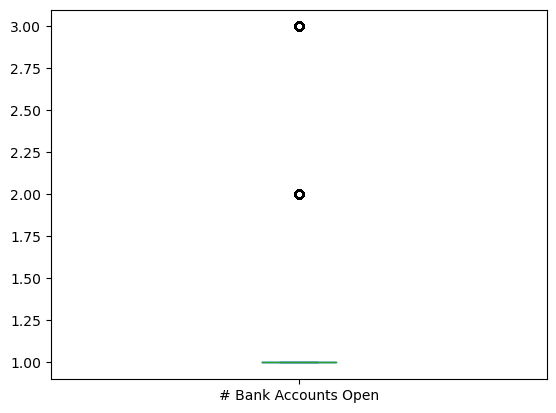

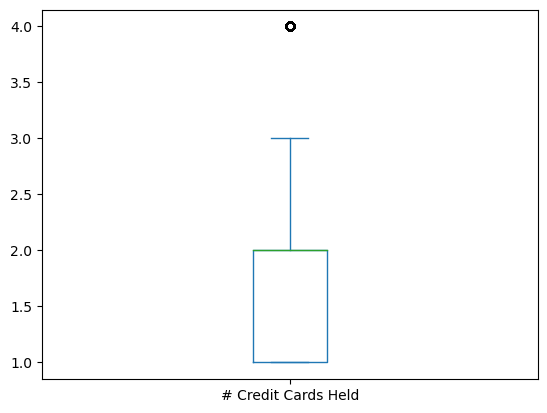

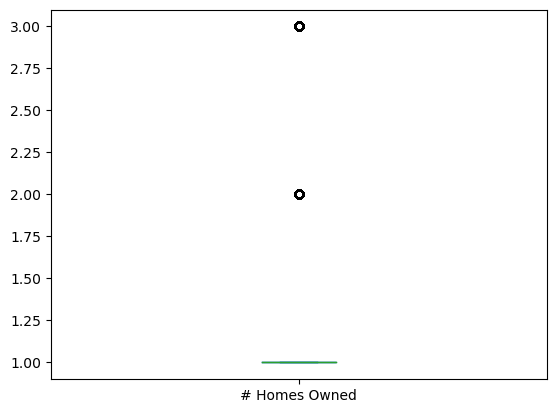

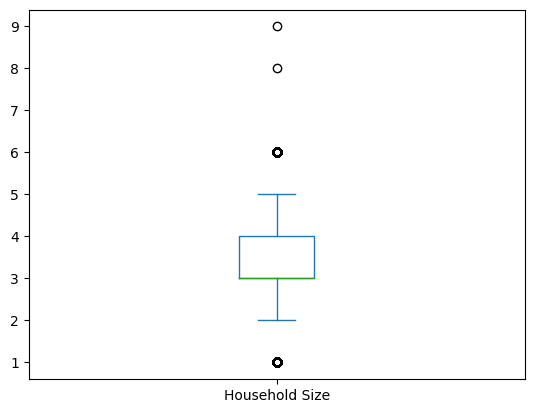

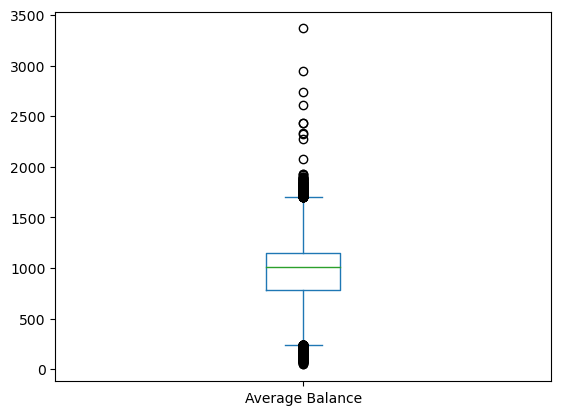

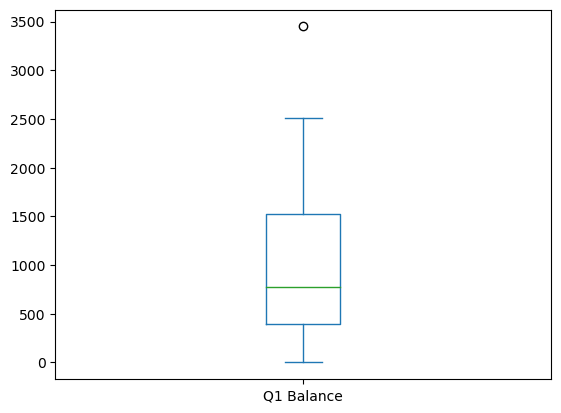

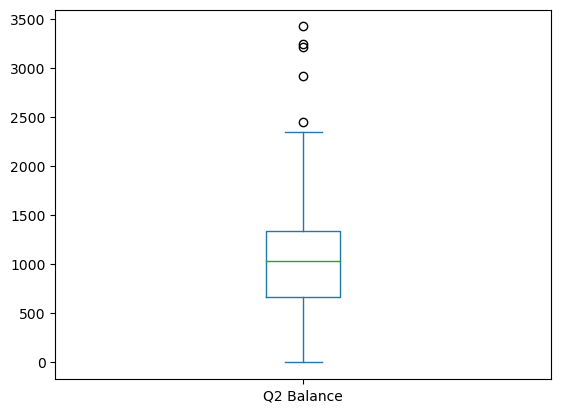

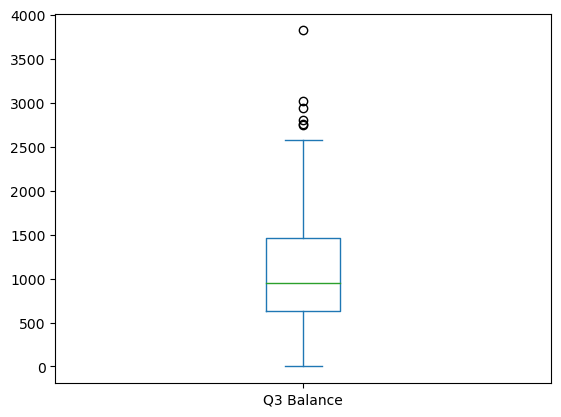

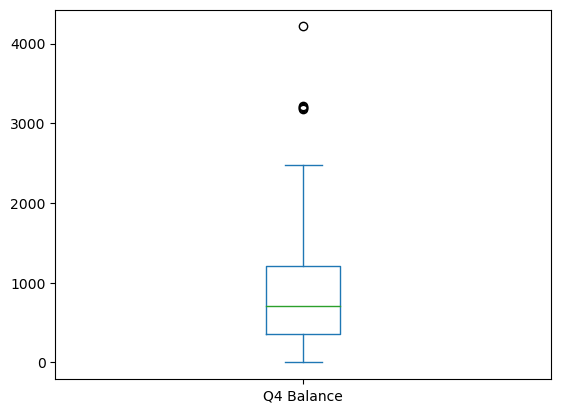

In [9]:
# e. Checking the presence of outliers
num_vars = ['# Bank Accounts Open', '# Credit Cards Held', '# Homes Owned', 'Household Size', 
            'Average Balance', 'Q1 Balance', 'Q2 Balance', 'Q3 Balance', 'Q4 Balance']

for var in num_vars:
    df[var].plot(kind='box')
    #plt.title(var)
    plt.show()

In [10]:
#5 point summary of numerical attributes
df.describe(include='all')

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance,Offer_Accepted_binary
count,18000.000000,18000,18000,18000,18000,18000.000000,18000,18000,18000.000000,18000.000000,18000.000000,18000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,18000.000000
unique,NaN,2,3,2,3,NaN,2,3,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,No,Air Miles,Postcard,Medium,NaN,No,High,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,16977,6061,9147,9013,NaN,15322,6071,NaN,NaN,NaN,11655,NaN,NaN,NaN,NaN,NaN,NaN
mean,9000.500000,NaN,NaN,NaN,NaN,1.255778,NaN,NaN,1.903500,1.203444,3.499056,NaN,940.515562,910.450656,999.392190,1042.033600,810.185803,0.056833
std,5196.296758,NaN,NaN,NaN,NaN,0.472501,NaN,NaN,0.797009,0.427341,1.114182,NaN,350.297837,620.077060,457.402268,553.452599,559.001365,0.231530
min,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,1.000000,1.000000,NaN,48.250000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4500.750000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,1.000000,3.000000,NaN,787.500000,392.750000,663.000000,633.000000,363.000000,0.000000
50%,9000.500000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,2.000000,1.000000,3.000000,NaN,1007.000000,772.000000,1032.000000,945.500000,703.000000,0.000000
75%,13500.250000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,2.000000,1.000000,4.000000,NaN,1153.250000,1521.000000,1342.000000,1463.000000,1212.000000,0.000000


In [11]:
df['Offer Accepted'].value_counts()

Offer Accepted
No     16977
Yes     1023
Name: count, dtype: int64

# Univariate analysis

### Histograms of continuous variables

C:\Users\Admin\AppData\Local\Temp\ipykernel_21888\2417630899.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])
C:\Users\Admin\AppData\Local\Temp\ipykernel_21888\2417630899.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])
C:\Users\Admin\AppData\Local\Temp\ipykernel_21888\24

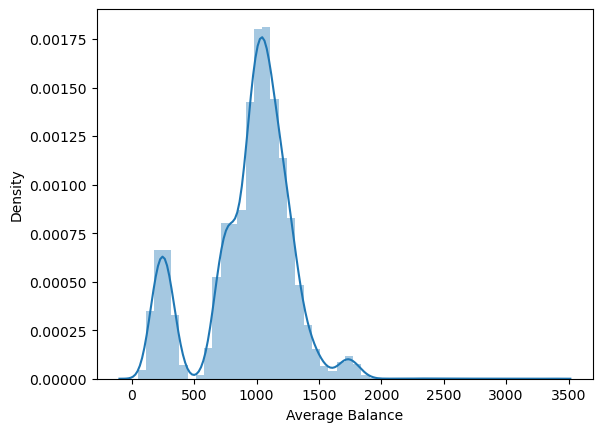

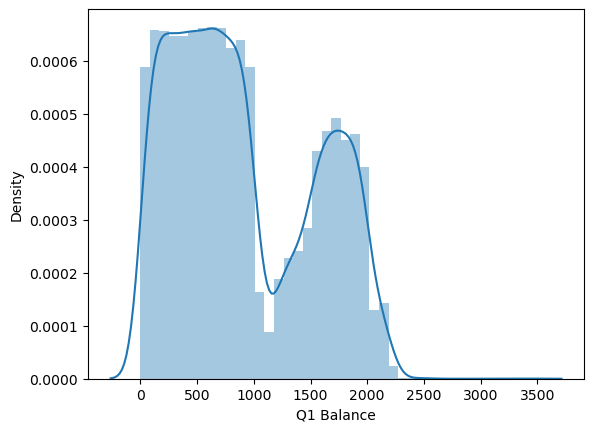

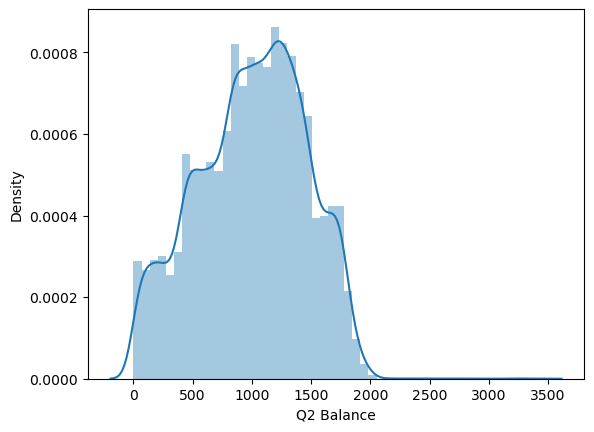

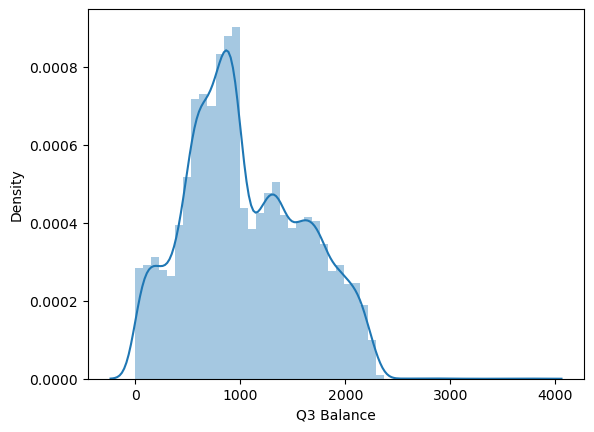

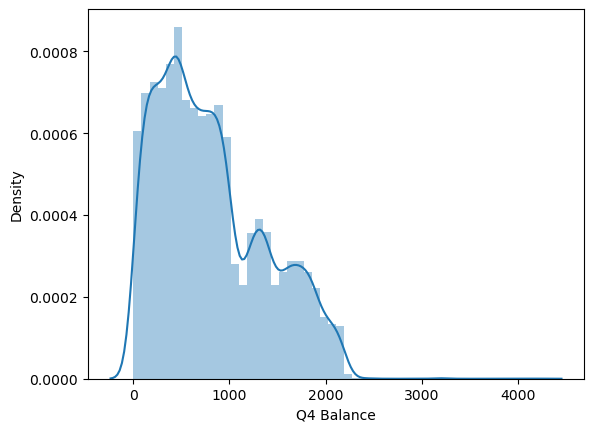

In [12]:
for col in df.select_dtypes('float'):
    plt.figure()
    sns.distplot(df[col])

### Qualitative Variables

In [13]:
for col in df.select_dtypes('object'):
    print(f'{col.ljust(25, "-") } {df[col].unique()}')

Offer Accepted----------- ['No' 'Yes']
Reward------------------- ['Air Miles' 'Cash Back' 'Points']
Mailer Type-------------- ['Letter' 'Postcard']
Income Level------------- ['High' 'Medium' 'Low']
Overdraft Protection----- ['No' 'Yes']
Credit Rating------------ ['High' 'Medium' 'Low']
Own Your Home------------ ['No' 'Yes']


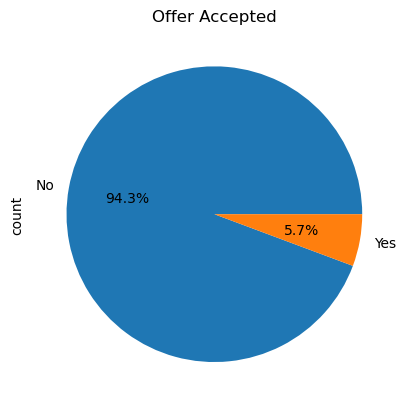

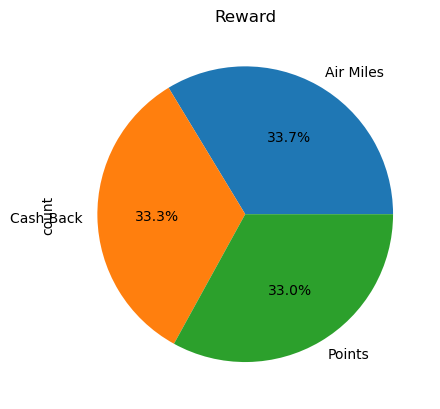

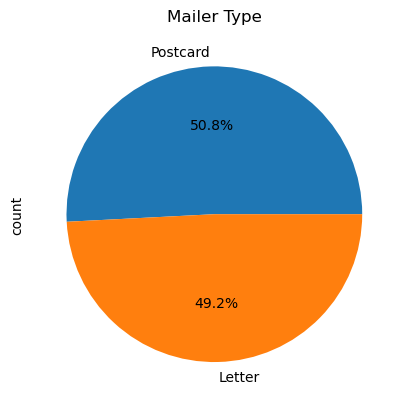

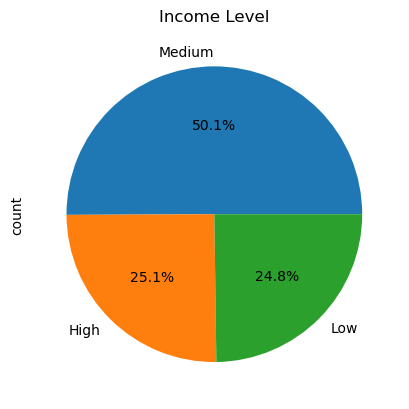

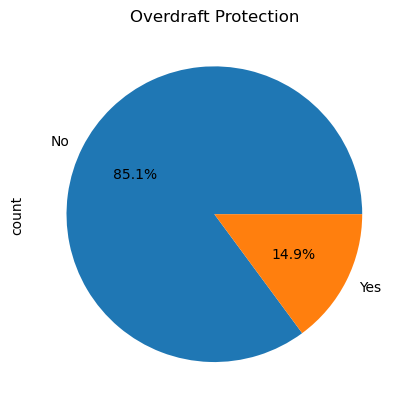

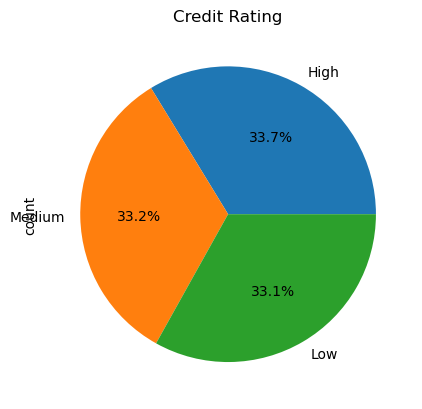

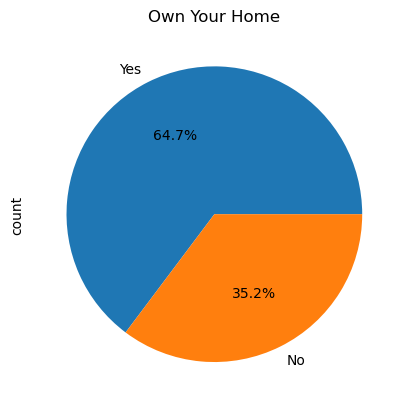

In [14]:
for col in df.select_dtypes('object'):
    df[col].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title(col)
    plt.show()

# Bivariate analysis: Target/Variables relationship

In [15]:
acceptation_df = df[df['Offer Accepted'] == 'Yes']

In [16]:
non_acceptation_df = df[df['Offer Accepted'] == 'No']

In [17]:
float_columns = []

for col in df.select_dtypes('float'):
    float_columns.append(col)

float_columns

['Average Balance', 'Q1 Balance', 'Q2 Balance', 'Q3 Balance', 'Q4 Balance']

In [18]:
int_columns = []

for col in df.select_dtypes('int'):
    int_columns.append(col)
    
int_columns

['Customer Number',
 '# Bank Accounts Open',
 '# Credit Cards Held',
 '# Homes Owned',
 'Household Size',
 'Offer_Accepted_binary']

In [19]:
cat_columns = []

for col in df.select_dtypes('object'):
    cat_columns.append(col)
    
cat_columns

['Offer Accepted',
 'Reward',
 'Mailer Type',
 'Income Level',
 'Overdraft Protection',
 'Credit Rating',
 'Own Your Home']

C:\Users\Admin\AppData\Local\Temp\ipykernel_21888\1059814763.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(acceptation_df[col], label='Accept')
C:\Users\Admin\AppData\Local\Temp\ipykernel_21888\1059814763.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(non_acceptation_df[col], label='R

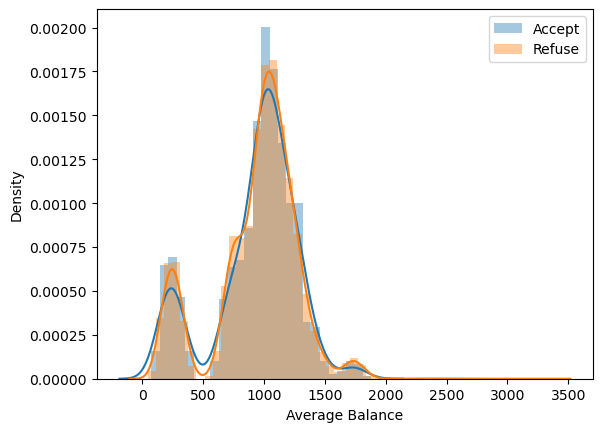

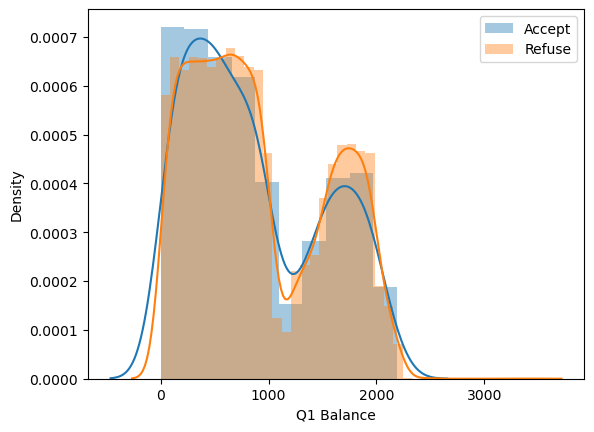

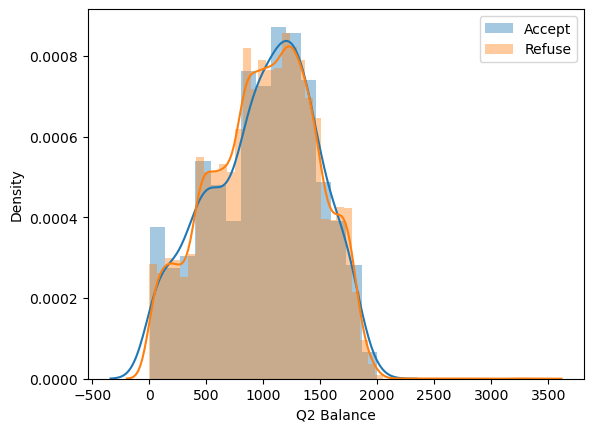

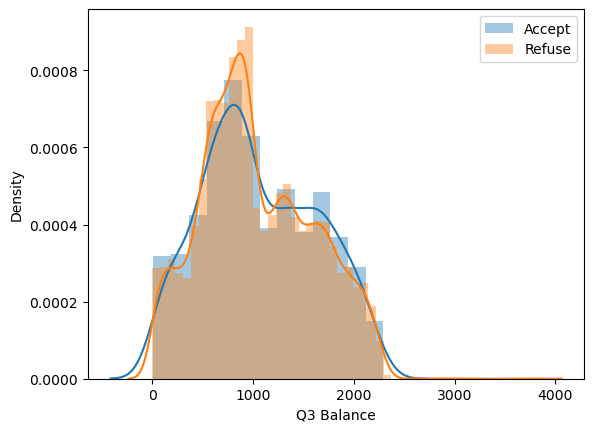

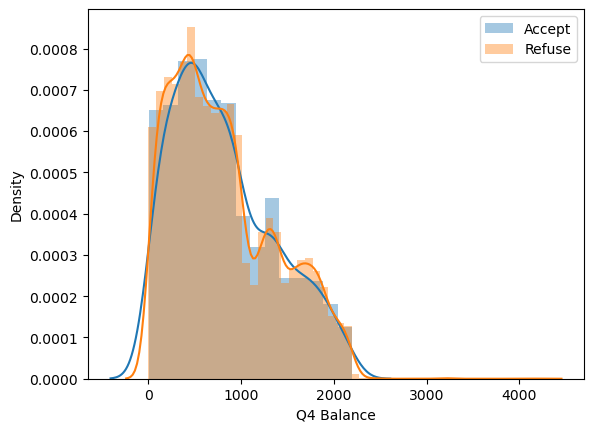

In [20]:
for col in df.select_dtypes('float'):
    plt.figure()
    sns.distplot(acceptation_df[col], label='Accept')
    sns.distplot(non_acceptation_df[col], label='Refuse')
    plt.legend()

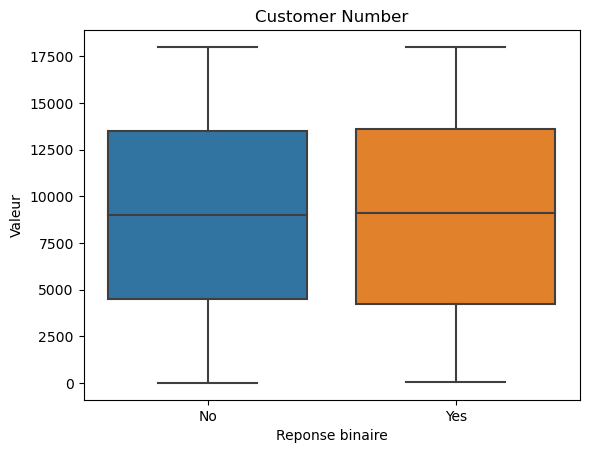

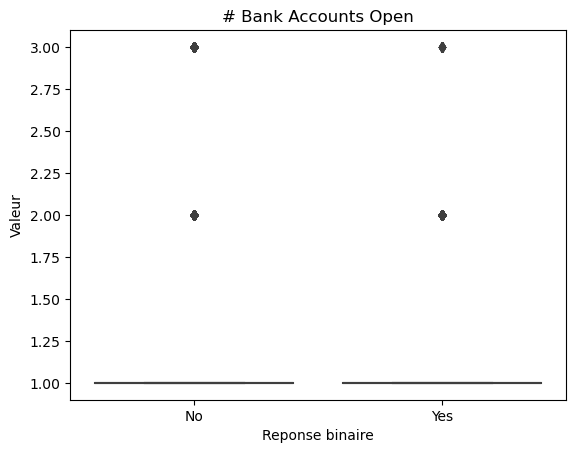

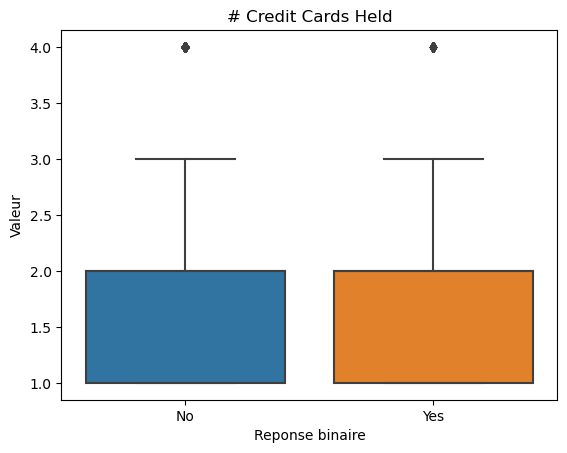

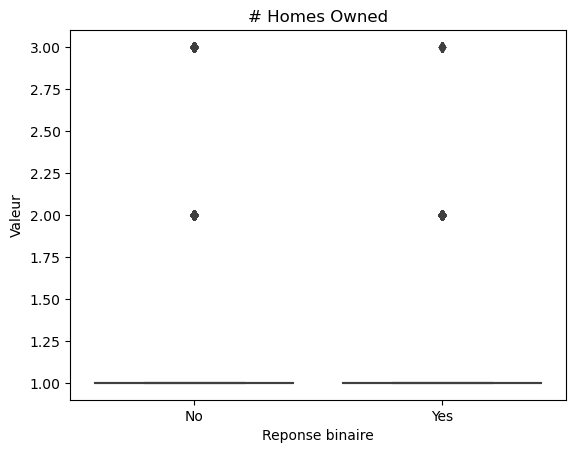

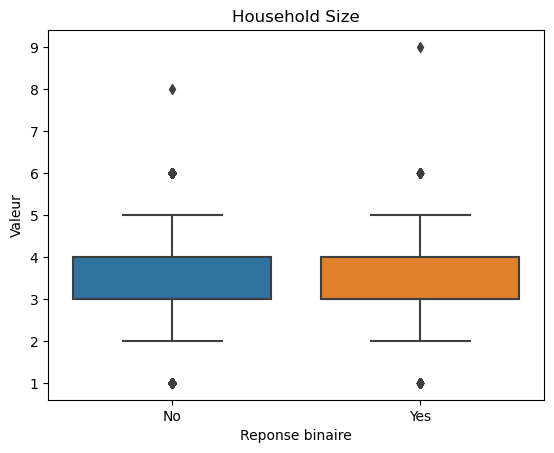

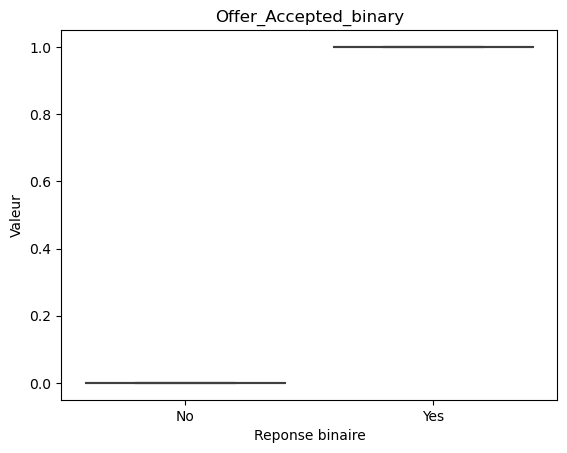

In [21]:
for var in int_columns:
    sns.boxplot(x="Offer Accepted", y=var, data=bankdata)
    plt.title(var)
    plt.xlabel('Reponse binaire')
    plt.ylabel('Valeur')
    plt.show()

In [22]:
# for col in df.select_dtypes('object'):
#     plt.figure()
#     sns.heatmap(pd.crosstab(df['Offer Accepted'], df[col]), annot=True, fmt='d')

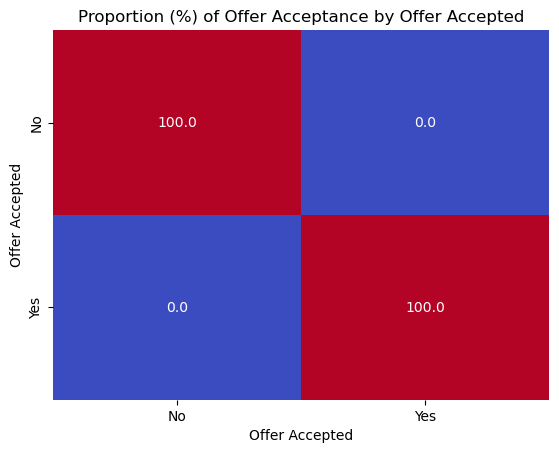

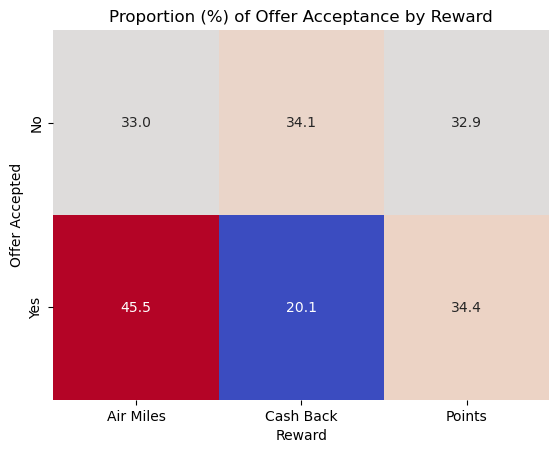

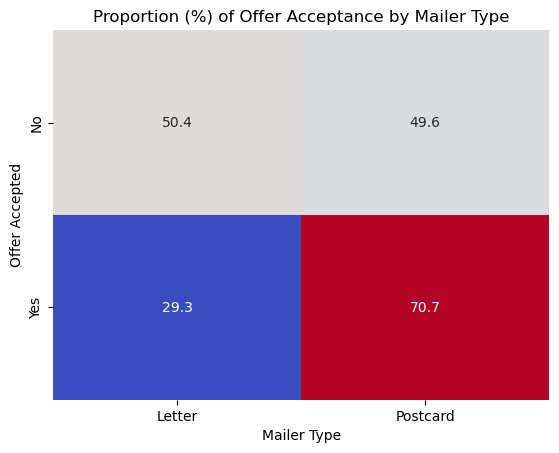

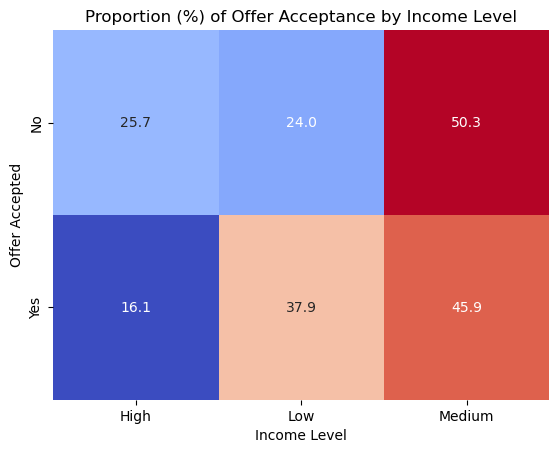

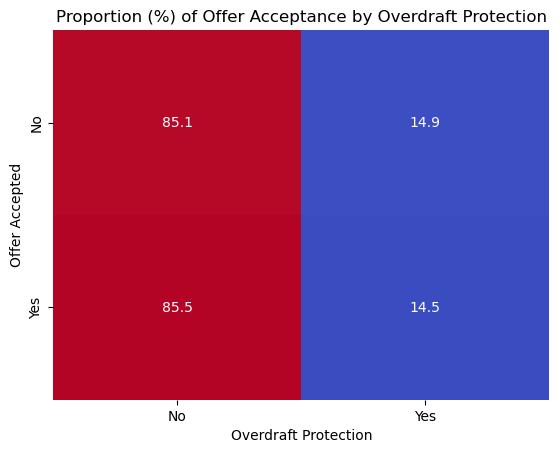

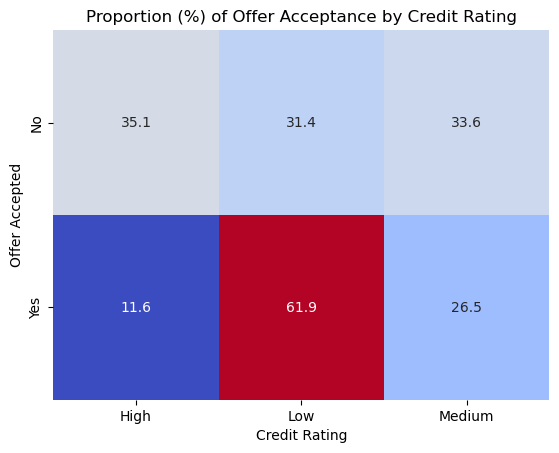

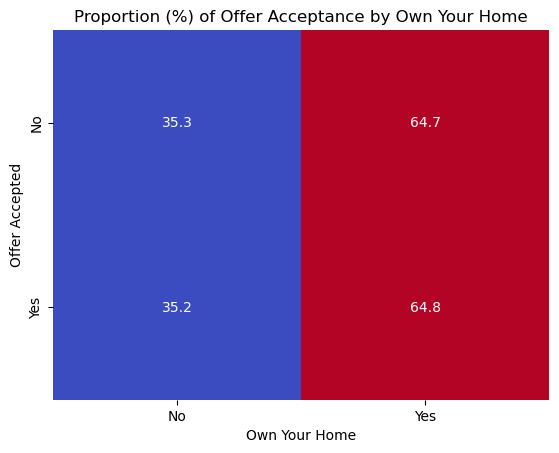

In [23]:
for col in df.select_dtypes('object'):
    plt.figure()
    crosstab_table = pd.crosstab(df['Offer Accepted'], df[col], normalize='index') * 100
    sns.heatmap(crosstab_table, annot=True, fmt='.1f', cmap='coolwarm', cbar=False)
    plt.title(f'Proportion (%) of Offer Acceptance by {col}')
    plt.xlabel(col)
    plt.ylabel('Offer Accepted')
    plt.show()


interpretation: We can say that the type of reward, the mailer type and a low credit rating improve the acceptance of the credit card offer.

# Let's confirm the hypotheses that the graphs gave us with statistical tests

### Handling missing values

In [24]:
missing_values = bankdata.isnull().sum()
missing_percent = (missing_values / len(bankdata)) * 100
missing_table = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
print(missing_table)

                       Missing Values  Percentage
Customer Number                     0    0.000000
Offer Accepted                      0    0.000000
Reward                              0    0.000000
Mailer Type                         0    0.000000
Income Level                        0    0.000000
# Bank Accounts Open                0    0.000000
Overdraft Protection                0    0.000000
Credit Rating                       0    0.000000
# Credit Cards Held                 0    0.000000
# Homes Owned                       0    0.000000
Household Size                      0    0.000000
Own Your Home                       0    0.000000
Average Balance                    24    0.133333
Q1 Balance                         24    0.133333
Q2 Balance                         24    0.133333
Q3 Balance                         24    0.133333
Q4 Balance                         24    0.133333
Offer_Accepted_binary               0    0.000000


In [25]:
# Select all rows containing NaN values
nan_rows = bankdata[bankdata.isnull().any(axis=1)]

# Show lines containing NaNs
pd.DataFrame(nan_rows)

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance,Offer_Accepted_binary
323,324,No,Points,Postcard,Medium,1,No,High,1,1,4,No,NaN,NaN,NaN,NaN,NaN,0
3070,3071,Yes,Air Miles,Postcard,Low,3,No,Medium,2,1,4,Yes,NaN,NaN,NaN,NaN,NaN,1
3108,3109,No,Air Miles,Letter,Low,1,No,High,3,1,4,Yes,NaN,NaN,NaN,NaN,NaN,0
3789,3790,No,Air Miles,Letter,Medium,2,No,High,3,1,3,No,NaN,NaN,NaN,NaN,NaN,0
5083,5084,No,Points,Letter,Medium,1,No,High,1,1,3,Yes,NaN,NaN,NaN,NaN,NaN,0
5677,5678,No,Air Miles,Postcard,Low,1,No,Low,2,1,4,Yes,NaN,NaN,NaN,NaN,NaN,0
5689,5690,No,Air Miles,Postcard,Medium,1,No,Medium,3,1,5,No,NaN,NaN,NaN,NaN,NaN,0
6932,6933,No,Air Miles,Postcard,Medium,1,No,Medium,2,2,4,Yes,NaN,NaN,NaN,NaN,NaN,0
7787,7788,No,Air Miles,Letter,Low,2,No,Low,1,1,4,Yes,NaN,NaN,NaN,NaN,NaN,0
7864,7865,No,Cash Back,Postcard,High,2,Yes,Low,2,1,3,No,NaN,NaN,NaN,NaN,NaN,0


In [26]:
pd.DataFrame(nan_rows).shape

(24, 18)

Interpretation: we can see here that the missing values are strongly correlated with each other, because they are linked to each other, we will therefore delete them because they only represent 0.133% of the data for each variable.

In [27]:
#drop 'NaN'
df = df.dropna(axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17976 entries, 0 to 17999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Customer Number        17976 non-null  int64  
 1   Offer Accepted         17976 non-null  object 
 2   Reward                 17976 non-null  object 
 3   Mailer Type            17976 non-null  object 
 4   Income Level           17976 non-null  object 
 5   # Bank Accounts Open   17976 non-null  int64  
 6   Overdraft Protection   17976 non-null  object 
 7   Credit Rating          17976 non-null  object 
 8   # Credit Cards Held    17976 non-null  int64  
 9   # Homes Owned          17976 non-null  int64  
 10  Household Size         17976 non-null  int64  
 11  Own Your Home          17976 non-null  object 
 12  Average Balance        17976 non-null  float64
 13  Q1 Balance             17976 non-null  float64
 14  Q2 Balance             17976 non-null  float64
 15  Q3 Bala

In [28]:
from scipy.stats import chi2_contingency

#initialer les listes pour stocker les resultats
var_names = []
chi2_stats = []
p_values = []
cramer_vs = []

#Parcourir toutes les variables categorielles
for var in cat_columns:
    #calculer le tableau de contingence
    contingenc_table = pd.crosstab(df['Offer Accepted'], df[var])
    #calculer la statistique de test du chi-deux et le p-value
    chi2, p, dof, expected = chi2_contingency(contingenc_table)
    #calcul le coefficient V de cramer
    n = contingenc_table.sum().sum()
    phi2 = chi2/n
    r,k = contingenc_table.shape
    phi2corr = max(0, phi2-(k-1)*(r-1))/(n-1)
    rc = r-((r-1)**2)/(n-1)
    kc = k-((k-1)**2)/(n-1)
    cramer_v = np.sqrt(phi2-((k-1)*(r-1))/(n-1))
    #ajouter les resultats aux listes correspondantes
    var_names.append(var)
    chi2_stats.append(chi2)
    p_values.append(p)
    cramer_vs.append(cramer_v)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21888\1071042405.py:22: RuntimeWarning: invalid value encountered in sqrt
  cramer_v = np.sqrt(phi2-((k-1)*(r-1))/(n-1))
C:\Users\Admin\AppData\Local\Temp\ipykernel_21888\1071042405.py:22: RuntimeWarning: invalid value encountered in sqrt
  cramer_v = np.sqrt(phi2-((k-1)*(r-1))/(n-1))


In [29]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Variable': var_names,
    'Chi2_statistic': chi2_stats,
    'P_value': p_values,
    "Cramer's_V": cramer_vs
})


# Sort the results DataFrame by Cramer's V coefficient in ascending order
sorted_results_df = results_df.sort_values(by="Cramer's_V", ascending=True)

# Display the sorted results
print(sorted_results_df)


               Variable  Chi2_statistic       P_value  Cramer's_V
1                Reward      101.147670  1.086582e-22    0.074267
3          Income Level      113.617605  2.129367e-25    0.078799
2           Mailer Type      169.039505  1.199365e-38    0.096685
5         Credit Rating      445.062142  2.269780e-97    0.156995
0        Offer Accepted    17957.338359  0.000000e+00    0.999453
4  Overdraft Protection        0.099898  7.519518e-01         NaN
6         Own Your Home        0.000000  1.000000e+00         NaN


In [30]:
import scipy.stats as stats

# Initialize lists to store the results
var_names = []
kw_stats = []
p_values = []

# Iterate over all numerical variables
for var in num_vars:
    # Calculate the groups of values
    groups = [df[df['Offer_Accepted_binary'] == 0][var], df[df['Offer_Accepted_binary'] == 1][var]]
    # Apply the Kruskal-Wallis test
    kw_stat, p = stats.kruskal(*groups)
    # Add the results to the corresponding lists
    var_names.append(var)
    kw_stats.append(kw_stat)
    p_values.append(p)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Variable': var_names,
    'Kruskal-Wallis': kw_stats,
    'P-value': p_values
})

# Sort the DataFrame in ascending order of p-value
results_df.sort_values(by='P-value', inplace=True)

# Display the results table
print(results_df)


               Variable  Kruskal-Wallis   P-value
5            Q1 Balance        5.997898  0.014323
3        Household Size        2.741845  0.097752
7            Q3 Balance        1.075692  0.299663
8            Q4 Balance        0.145636  0.702741
1   # Credit Cards Held        0.118703  0.730445
6            Q2 Balance        0.067323  0.795276
4       Average Balance        0.015696  0.900299
0  # Bank Accounts Open        0.001363  0.970551
2         # Homes Owned        0.000988  0.974931


## Slightly more advanced analysis

### Relationship between continuous variables

C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


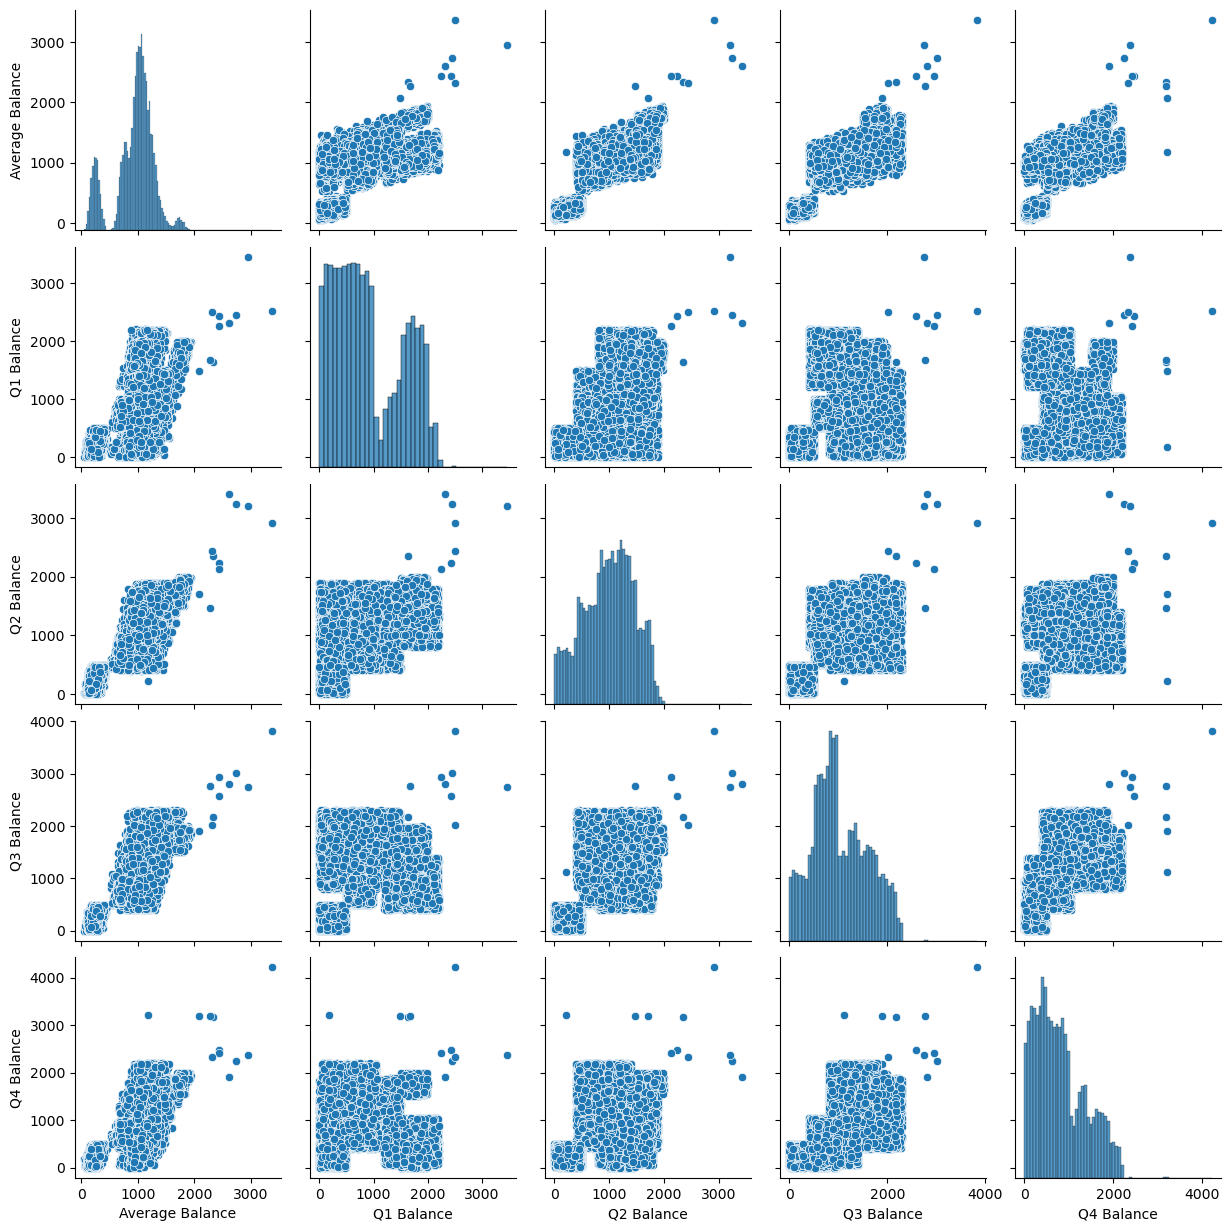

In [31]:
sns.pairplot(df[float_columns])

<Axes: >

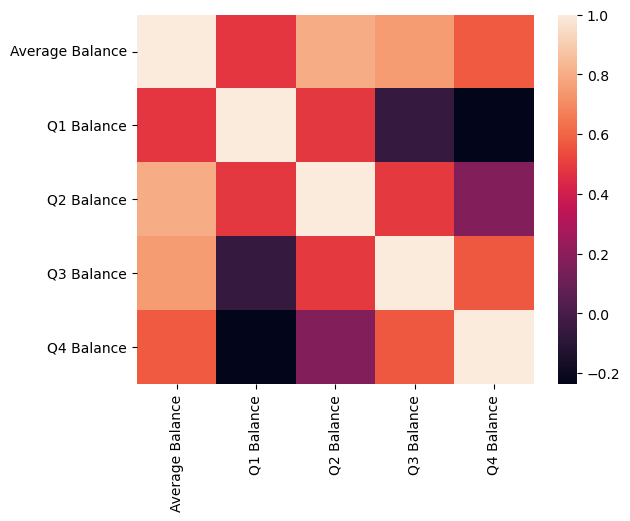

In [32]:
sns.heatmap(df[float_columns].corr())

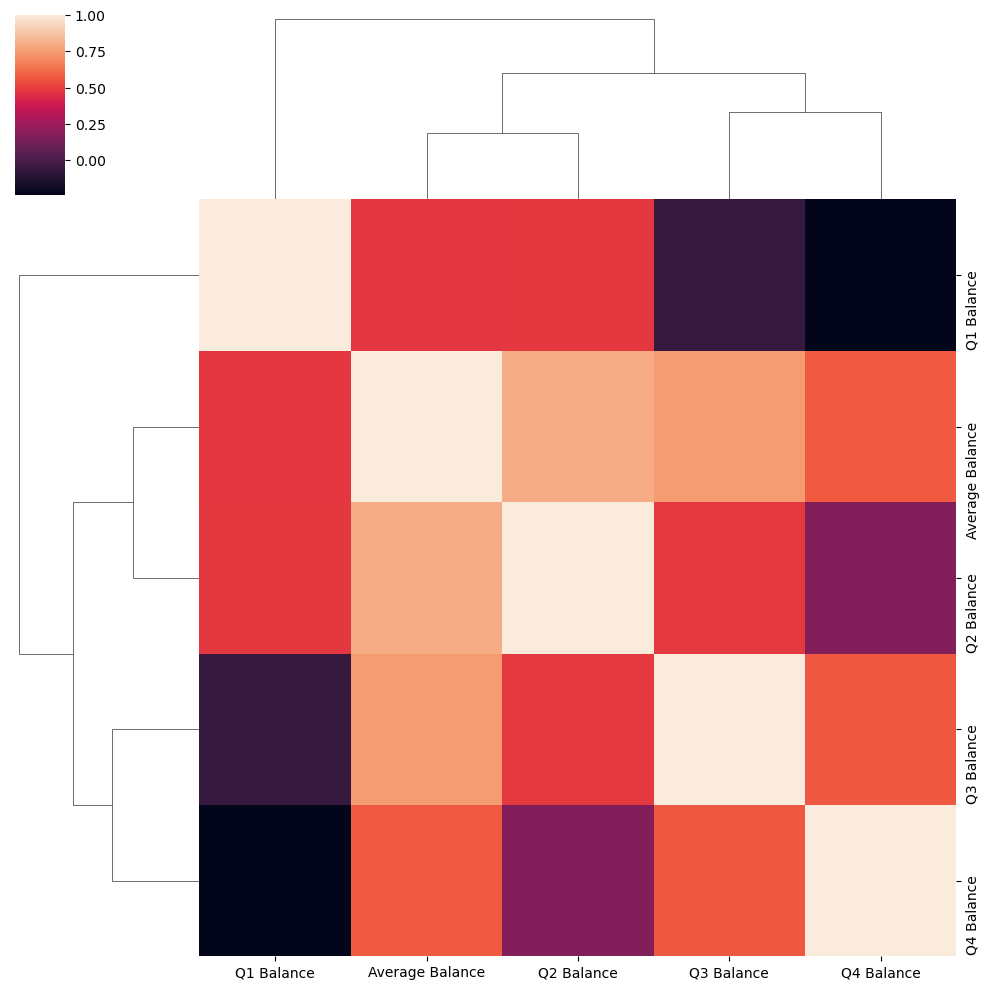

In [33]:
sns.clustermap(df[float_columns].corr())

In [34]:
for col in cat_columns:
    print(f"Contingency table for {col}:\n")
    print(pd.crosstab(df[col], df[col]))
    print("\n")

Contingency table for Offer Accepted:

Offer Accepted     No   Yes
Offer Accepted             
No              16955     0
Yes                 0  1021


Contingency table for Reward:

Reward     Air Miles  Cash Back  Points
Reward                                 
Air Miles       6047          0       0
Cash Back          0       5995       0
Points             0          0    5934


Contingency table for Mailer Type:

Mailer Type  Letter  Postcard
Mailer Type                  
Letter         8842         0
Postcard          0      9134


Contingency table for Income Level:

Income Level  High   Low  Medium
Income Level                    
High          4519     0       0
Low              0  4455       0
Medium           0     0    9002


Contingency table for Overdraft Protection:

Overdraft Protection     No   Yes
Overdraft Protection             
No                    15300     0
Yes                       0  2676


Contingency table for Credit Rating:

Credit Rating  High   Low  Medi

Interpretation: Here we check if there are people who are undecided, who have divided opinions, and we see that no, this means that the individuals are sure of the decision they are making.

In [35]:
df.head()

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance,Offer_Accepted_binary
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0,0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0,0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0,0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0,0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0,0


# Preprocessing

In [36]:
label_encoder = LabelEncoder()
cat_columns

['Offer Accepted',
 'Reward',
 'Mailer Type',
 'Income Level',
 'Overdraft Protection',
 'Credit Rating',
 'Own Your Home']

In [37]:
le_reward = LabelEncoder()
df['Reward'] = le_reward.fit_transform(df['Reward'])
df.Reward.unique()

array([0, 1, 2])

In [38]:
le_mailerType = LabelEncoder()
df['Mailer Type'] = le_mailerType.fit_transform(df['Mailer Type'])
df['Mailer Type'].unique()

array([0, 1])

In [39]:
le_incomeLevel = LabelEncoder()
df['Income Level'] = le_incomeLevel.fit_transform(df['Income Level'])
df['Income Level'].unique()

array([0, 2, 1])

In [40]:
le_overdraftProtection = LabelEncoder()
df['Overdraft Protection'] = le_overdraftProtection.fit_transform(df['Overdraft Protection'])
df['Overdraft Protection'].unique()

array([0, 1])

In [41]:
le_creditRating = LabelEncoder()
df['Credit Rating'] = le_creditRating.fit_transform(df['Credit Rating'])
df['Credit Rating'].unique()

array([0, 2, 1])

In [42]:
le_homeOwner = LabelEncoder()
df['Own Your Home'] = le_homeOwner.fit_transform(df['Own Your Home'])
df['Own Your Home'].unique()

array([0, 1])

In [43]:
df.head()

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance,Offer_Accepted_binary
0,1,No,0,0,0,1,0,0,2,1,4,0,1160.75,1669.0,877.0,1095.0,1002.0,0
1,2,No,0,0,2,1,0,2,2,2,5,1,147.25,39.0,106.0,78.0,366.0,0
2,3,No,0,1,0,2,0,2,2,1,2,1,276.50,367.0,352.0,145.0,242.0,0
3,4,No,0,0,2,2,0,0,1,1,4,0,1219.00,1578.0,1760.0,1119.0,419.0,0
4,5,No,0,0,2,1,0,2,2,1,6,1,1211.00,2140.0,1357.0,982.0,365.0,0


# Basic model

In [44]:
#Split data into X (features) and y (label)

X = df.drop(['Offer Accepted', 'Offer_Accepted_binary', 'Customer Number'], axis=1)
y = df['Offer_Accepted_binary']

In [45]:
#Split data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [46]:
LogisticReg = LogisticRegression(random_state=42, max_iter=1000)
DecisionTree = DecisionTreeClassifier(random_state=42)
RandomForest = RandomForestClassifier(n_estimators=100 ,random_state=42)

In [47]:
dict_of_models = {
    'LogisticReg': LogisticReg,
    'DecisionTree': DecisionTree,
    'RandomForest': RandomForest
}

In [48]:
def evaluation(model):
    # Train the model
    result = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    # Display model scores
    train_score = result.score(X_train, y_train)
    test_score = result.score(X_test, y_test)
    print("Train Score:", train_score)
    print("Test Score:", test_score)


    # Display confusion matrix and classification report
    y_pred = result.predict(X_test)
    print('Accuracy of model on test set: {:.2f}'.format(result.score(X_test, y_test)))

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)

    # Print the classification report
    print(classification_report(y_test, y_pred))
    
    # Compute learning curve with F1 score for the positive class (1)
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                               cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1.0, 10))
    
    # Plot learning curve
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='Train F1 Score')
    plt.plot(N, val_score.mean(axis=1), label='Validation F1 Score')
    plt.xlabel('Number of Training Samples')
    plt.ylabel('F1 Score')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

LogisticReg


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi

Train Score: 0.9435326842837274
Test Score: 0.9418798665183538
Accuracy of model on test set: 0.94
[[3387    0]
 [ 209    0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3387
           1       0.00      0.00      0.00       209

    accuracy                           0.94      3596
   macro avg       0.47      0.50      0.49      3596
weighted avg       0.89      0.94      0.91      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

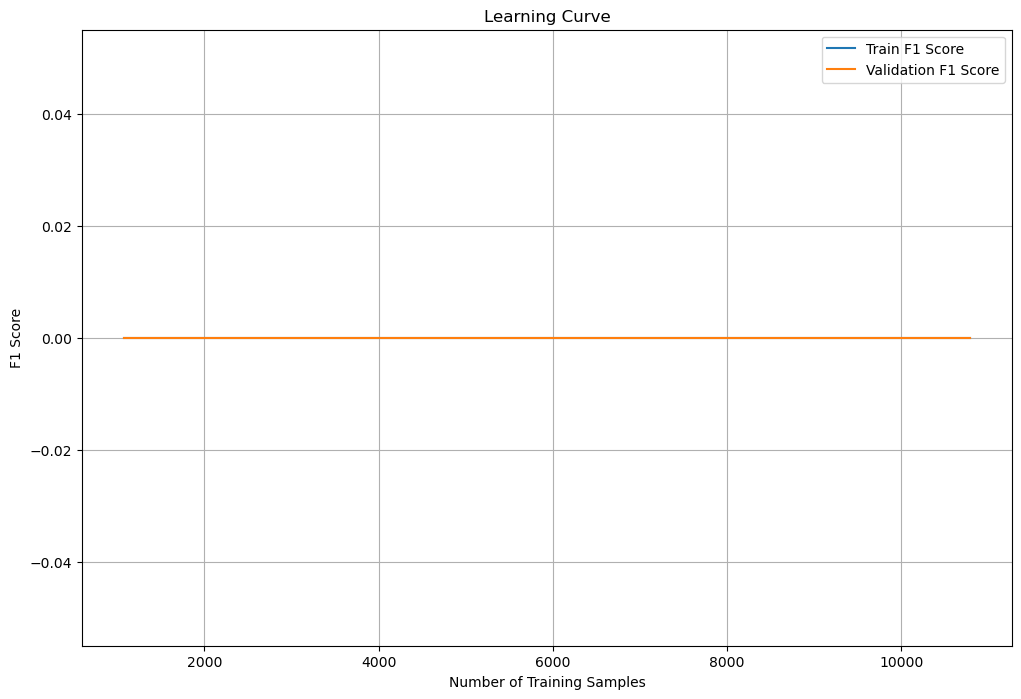

DecisionTree
Train Score: 1.0
Test Score: 0.8773637374860956
Accuracy of model on test set: 0.88
[[3131  256]
 [ 185   24]]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3387
           1       0.09      0.11      0.10       209

    accuracy                           0.88      3596
   macro avg       0.51      0.52      0.52      3596
weighted avg       0.89      0.88      0.89      3596



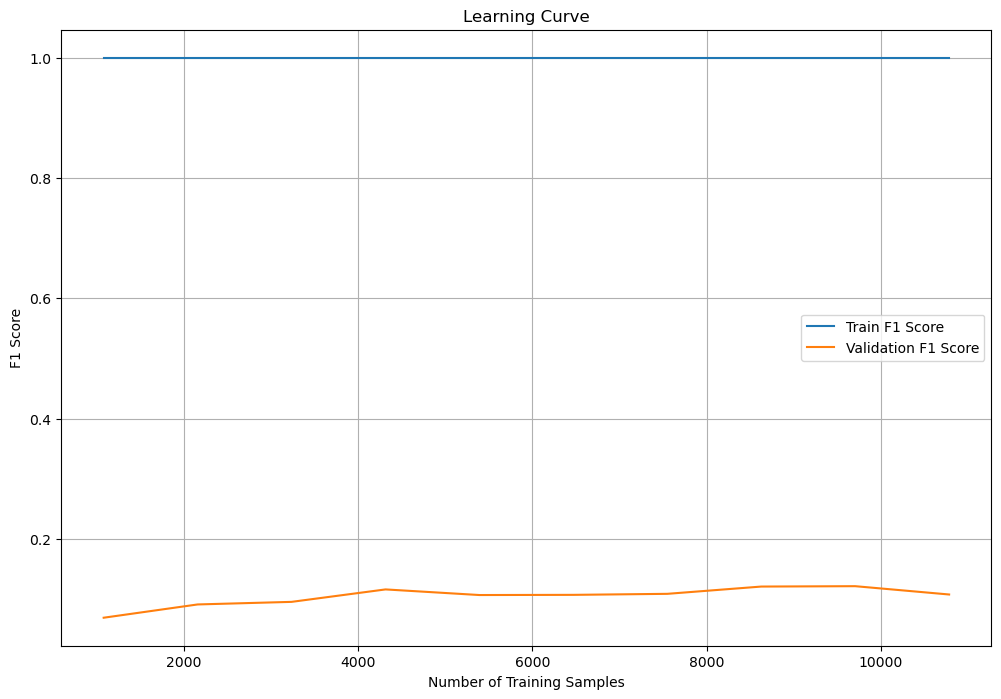

RandomForest
Train Score: 0.9997913769123783
Test Score: 0.9418798665183538
Accuracy of model on test set: 0.94
[[3387    0]
 [ 209    0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3387
           1       0.00      0.00      0.00       209

    accuracy                           0.94      3596
   macro avg       0.47      0.50      0.49      3596
weighted avg       0.89      0.94      0.91      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


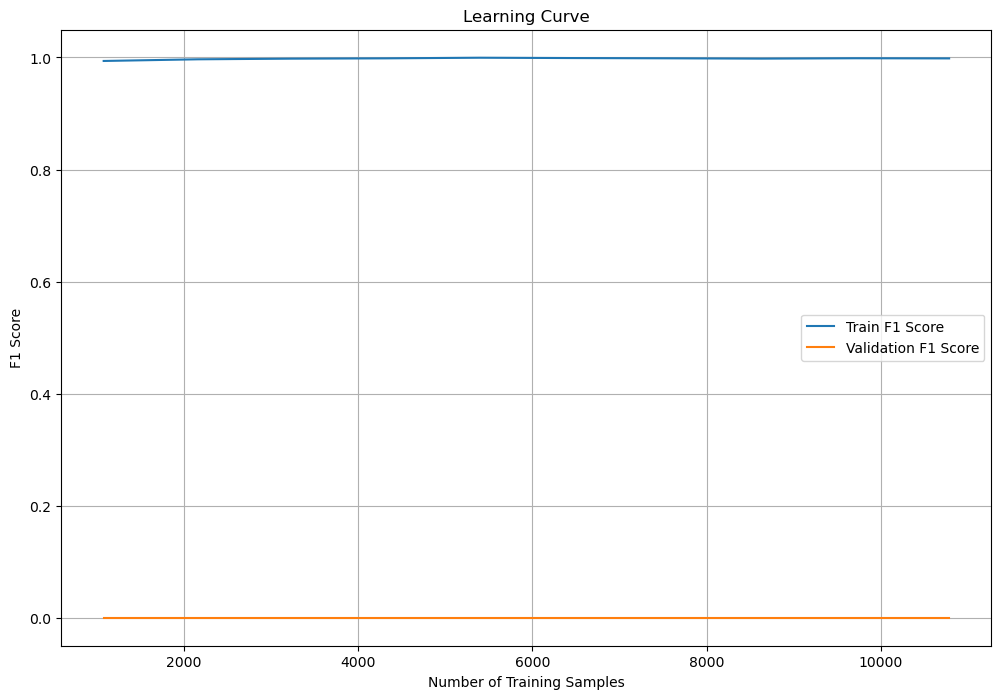

In [49]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)


Interpretation: We see that the model is very effective on the data it has trained regarding customers who did not accept the credit card offer, but less effective on the new data it is given , especially on the data of customers who accepted the offer, and this is due to the fact that the trained data was unbalanced. And for the moment it is the decision tree model which gives us the best result

### Let's balance our dataset with the Smote method

In [50]:
#Let's try to balance the database with the SMOTE method

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Create a new DataFrame with the sampled data
df_smote = pd.concat([X_train_smote, y_train_smote], axis=1)

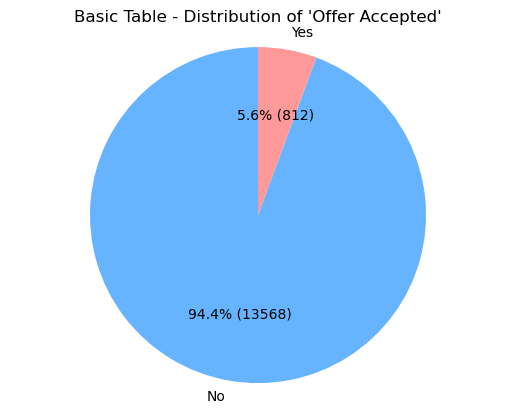

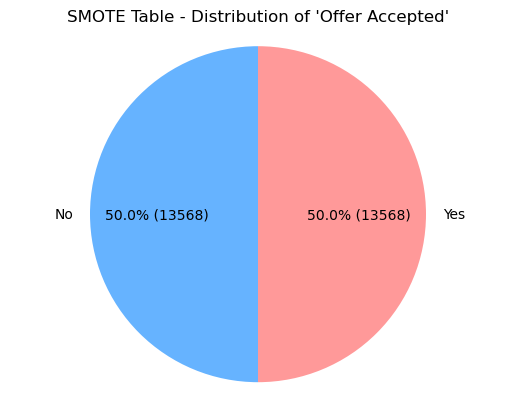

In [51]:
import matplotlib.pyplot as plt

# Function to create a pie chart with proportions and numbers
def plot_pie_chart(y, title):
    labels = ['No', 'Yes']
    sizes = y.value_counts().values
    colors = ['#66b3ff', '#ff9999']
    
    # Modify the format of the labels to include proportions and numbers
    def autopct_format(pct, all_values):
        absolute = int(round(pct / 100 * sum(all_values)))
        return f"{pct:.1f}% ({absolute})"

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: autopct_format(pct, sizes), startangle=90)
    ax.axis('equal')  
    plt.title(title)
    plt.show()

# Create a pie chart for the basic table
plot_pie_chart(y_train, "Basic Table - Distribution of 'Offer Accepted'")

# Create a pie chart for the oversampled table
plot_pie_chart(y_train_smote, "SMOTE Table - Distribution of 'Offer Accepted'")


In [52]:
df_smote

,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance,Offer_Accepted_binary
0,1,0,1,1,0,2,1,1,5,0,1156.250000,430.000000,708.000000,1661.000000,1826.000000,0
1,2,1,0,1,0,1,3,2,5,1,258.250000,212.000000,129.000000,387.000000,305.000000,0
2,1,0,2,1,0,0,1,2,2,0,1005.250000,143.000000,417.000000,1490.000000,1971.000000,0
3,1,1,0,1,1,1,1,1,6,0,1036.250000,63.000000,1116.000000,1871.000000,1095.000000,0
4,1,1,2,2,0,2,1,1,2,0,1210.000000,802.000000,1284.000000,1712.000000,1042.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27131,1,0,1,1,0,0,2,1,3,1,1239.891161,1126.652081,1263.238645,1347.863823,1221.810097,1
27132,0,1,1,1,0,1,1,1,3,1,1317.856220,1094.855244,630.117892,1572.376890,1974.074856,1
27133,1,1,1,1,0,0,1,1,3,0,1026.138768,216.646636,1194.657369,1638.627323,1054.623745,1
27134,0,1,1,1,0,0,1,1,3,0,1159.572222,874.277182,550.129184,1587.931525,1625.950996,1


# Basic model with balanced data

In [53]:
result = model.fit(X_train_smote, y_train_smote)

In [54]:
def evaluation(model):
    # Train the model
    result = model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    
    
    # Display model scores
    train_score = result.score(X_train_smote, y_train_smote)
    test_score = result.score(X_test, y_test)
    print("Train Score:", train_score)
    print("Test Score:", test_score)


    # Display confusion matrix and classification report
    y_pred = result.predict(X_test)
    print('Accuracy of model on test set: {:.2f}'.format(result.score(X_test, y_test)))

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)

    # Print the classification report
    print(classification_report(y_test, y_pred))
    
    # Compute learning curve with F1 score for the positive class (1)
    N, train_score, val_score = learning_curve(model, X_train_smote, y_train_smote,
                                               cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1.0, 10))
    
        
    # Plot learning curve
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='Train F1 Score')
    plt.plot(N, val_score.mean(axis=1), label='Validation F1 Score')
    plt.xlabel('Number of Training Samples')
    plt.ylabel('F1 Score')
    plt.title(f'Learning Curve for {model.__class__.__name__}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compute ROC AUC score and plot ROC curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    
    roc_auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    plt.figure(figsize=(12, 8))
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model.__class__.__name__}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

LogisticReg


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Score: 0.7401975235849056
Test Score: 0.6988320355951056
Accuracy of model on test set: 0.70
[[2446  941]
 [ 142   67]]
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      3387
           1       0.07      0.32      0.11       209

    accuracy                           0.70      3596
   macro avg       0.51      0.52      0.46      3596
weighted avg       0.89      0.70      0.78      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

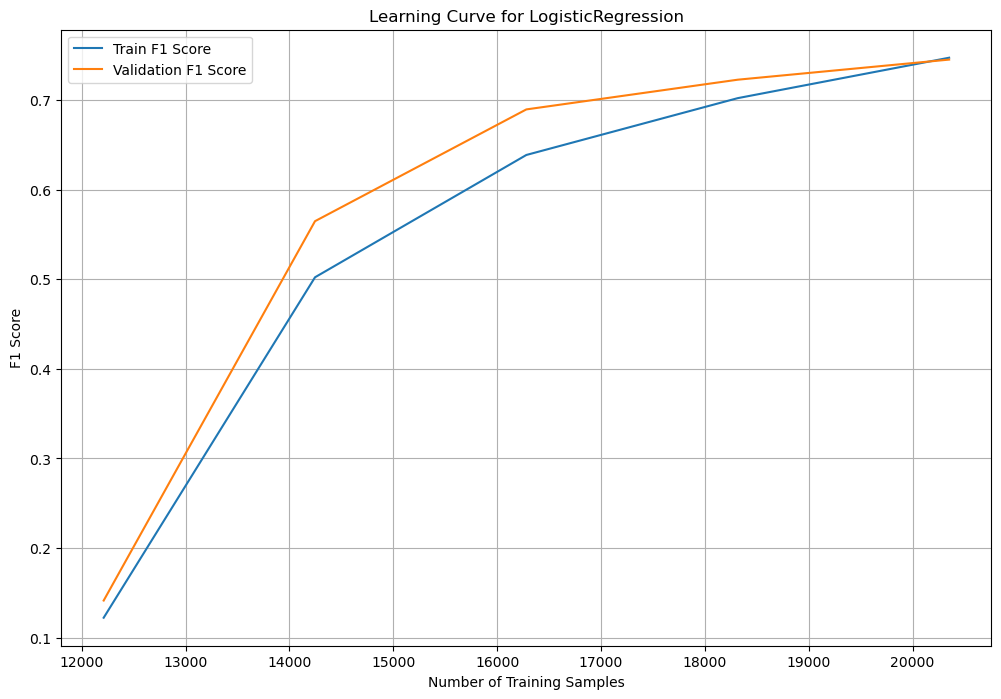

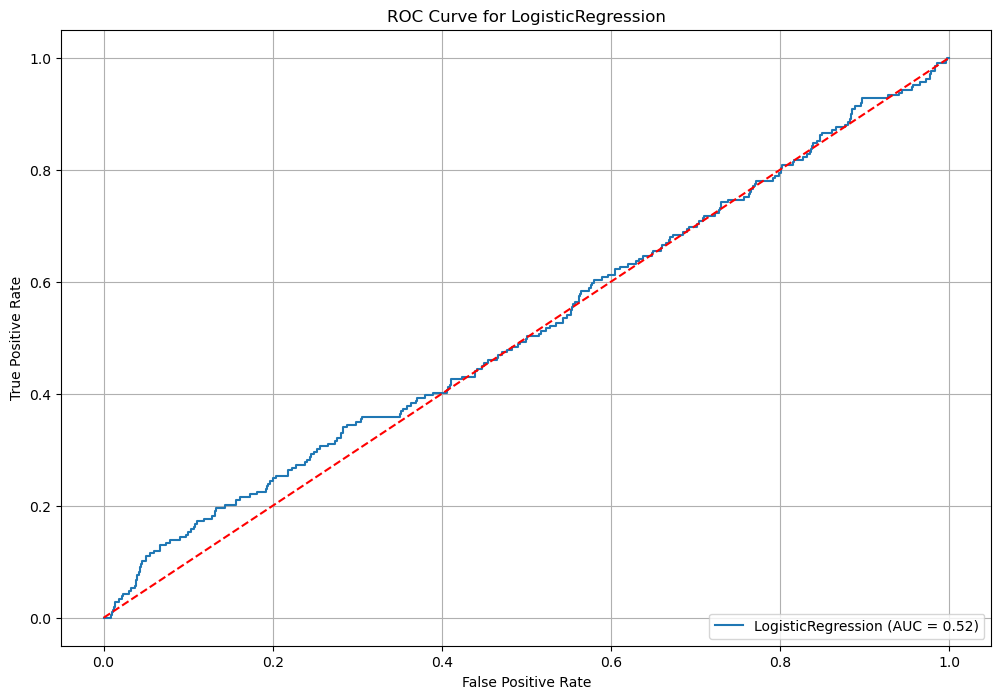

DecisionTree
Train Score: 1.0
Test Score: 0.8114571746384872
Accuracy of model on test set: 0.81
[[2872  515]
 [ 163   46]]
              precision    recall  f1-score   support

           0       0.95      0.85      0.89      3387
           1       0.08      0.22      0.12       209

    accuracy                           0.81      3596
   macro avg       0.51      0.53      0.51      3596
weighted avg       0.90      0.81      0.85      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

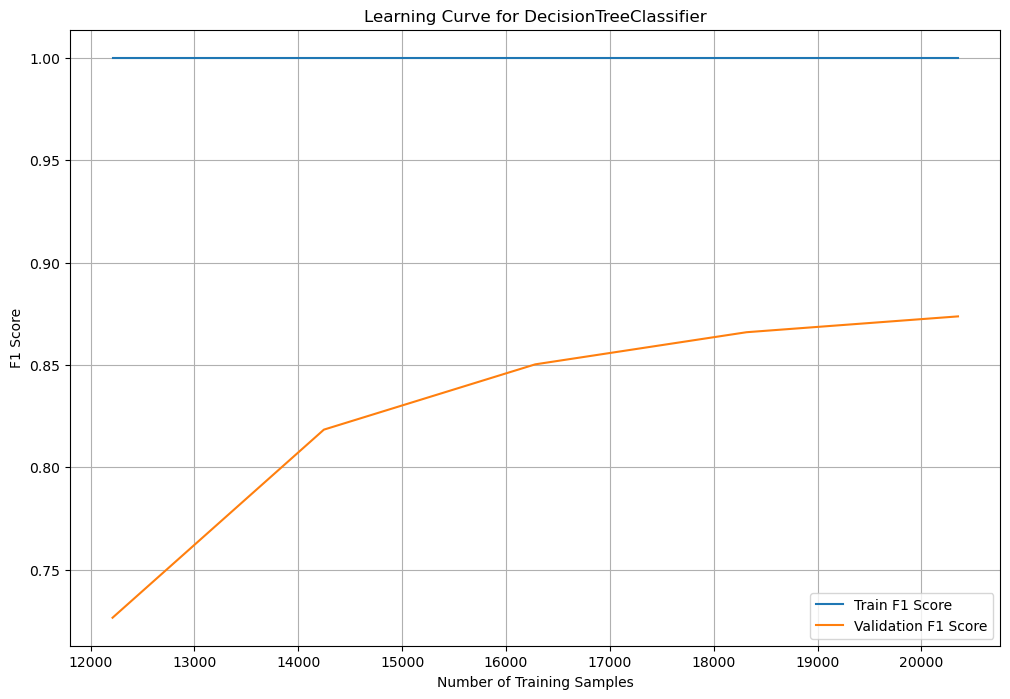

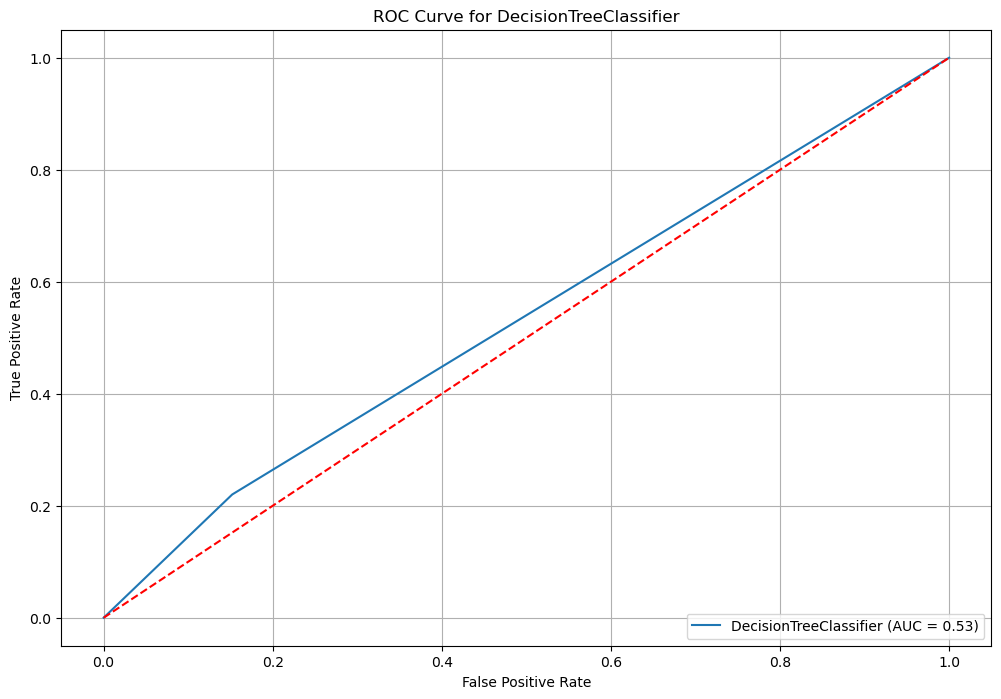

RandomForest
Train Score: 1.0
Test Score: 0.8837597330367074
Accuracy of model on test set: 0.88
[[3153  234]
 [ 184   25]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3387
           1       0.10      0.12      0.11       209

    accuracy                           0.88      3596
   macro avg       0.52      0.53      0.52      3596
weighted avg       0.90      0.88      0.89      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

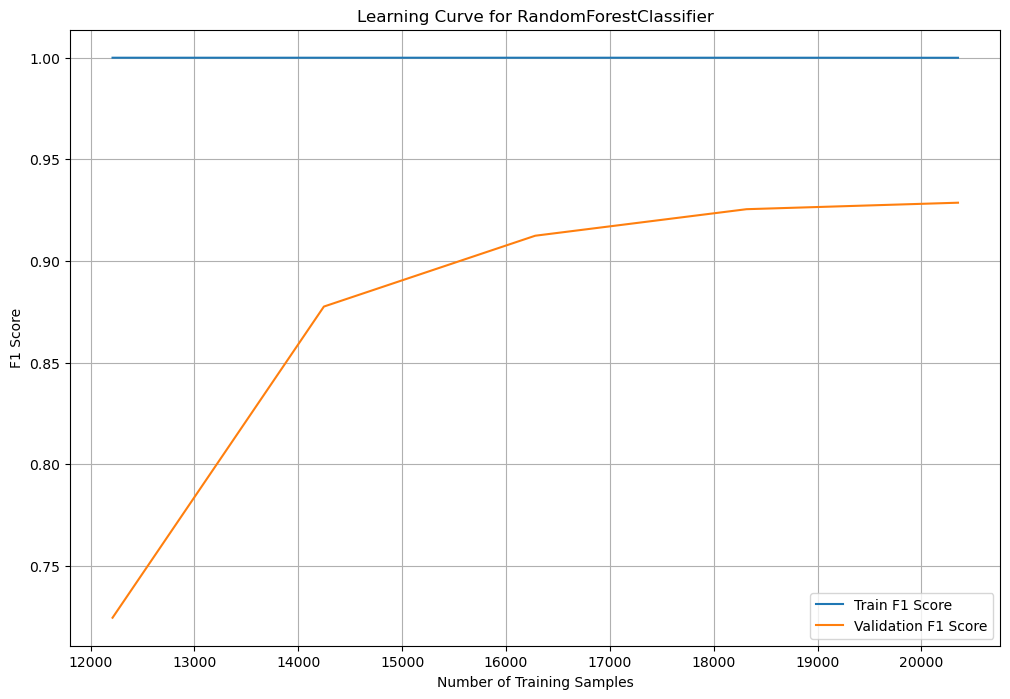

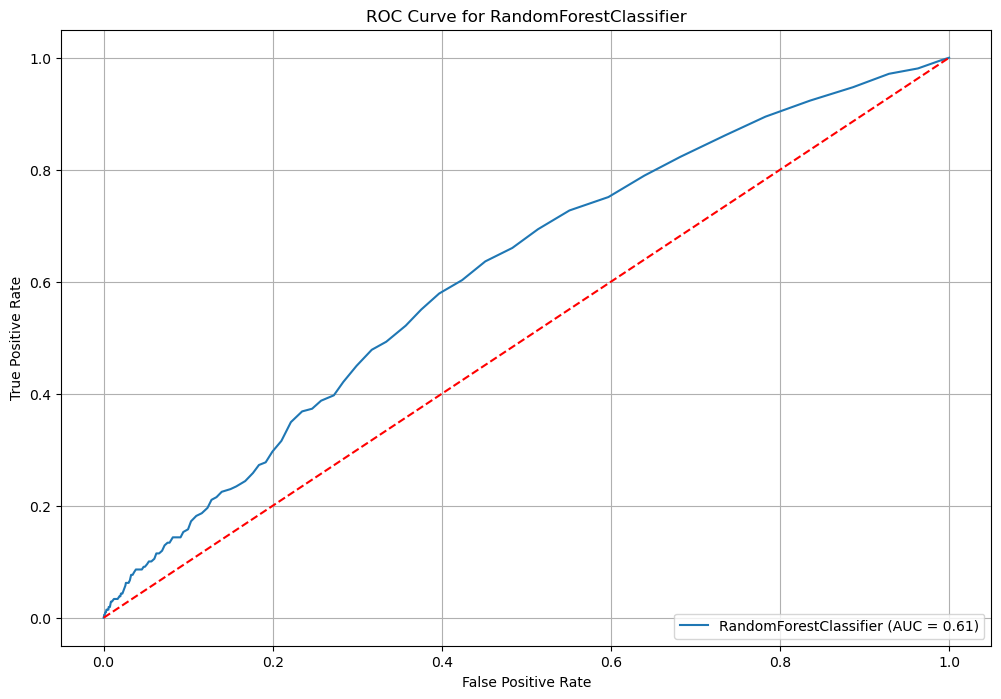

In [55]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

Interpretation: Here we can see that it is the Ramdon Forest model that performs the best, because it obtains a score of 100% on the trained data and 88% on the data that it has never seen. There are still some overfittings and this is the problem that we are going to correct now.

# Final Modelisation

In [56]:
#LogisticReg = LogisticRegression(random_state=42, max_iter=1000)
#DecisionTree = DecisionTreeClassifier(random_state=42)
RandomForest = RandomForestClassifier(n_estimators=100 ,random_state=42)

Train Score: 1.0
Test Score: 0.8837597330367074
Accuracy of model on test set: 0.88
[[3153  234]
 [ 184   25]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3387
           1       0.10      0.12      0.11       209

    accuracy                           0.88      3596
   macro avg       0.52      0.53      0.52      3596
weighted avg       0.90      0.88      0.89      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

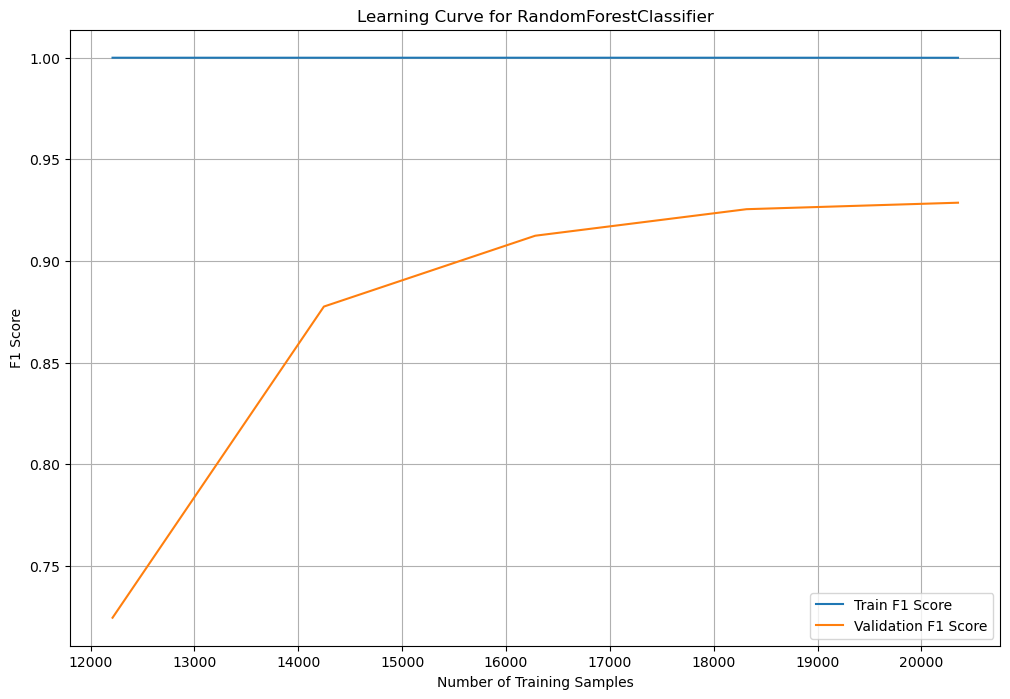

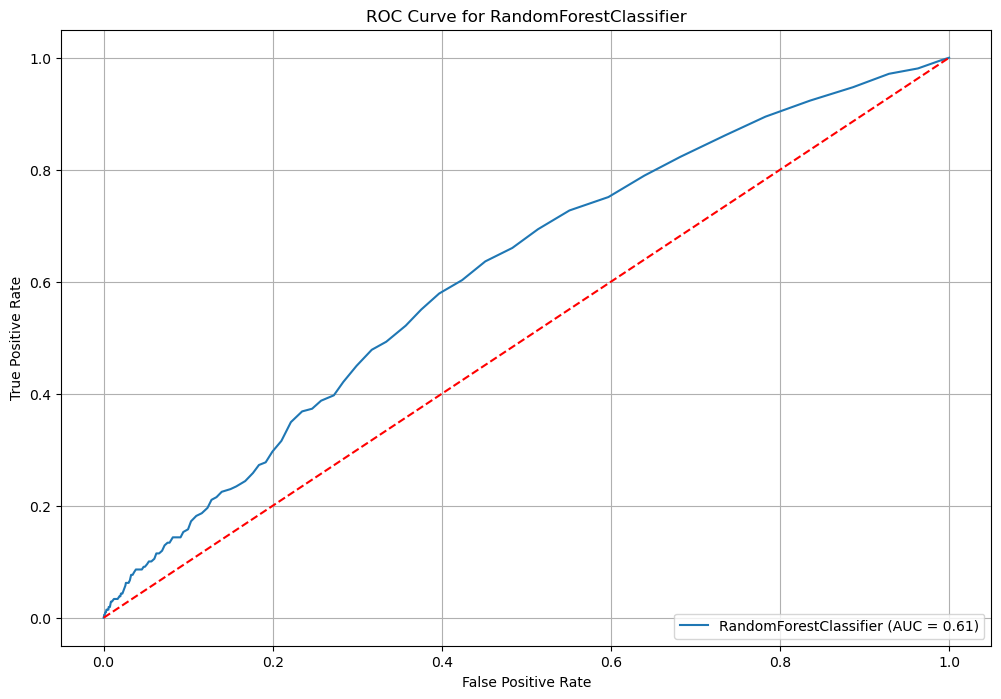

In [57]:
evaluation(model)

In [58]:
model.feature_importances_

array([0.05901916, 0.01543963, 0.08114245, 0.02973208, 0.02819634,
       0.13203754, 0.04508594, 0.03262913, 0.05354075, 0.03672294,
       0.0950647 , 0.09787285, 0.09759149, 0.09614437, 0.09978063])

<Axes: >

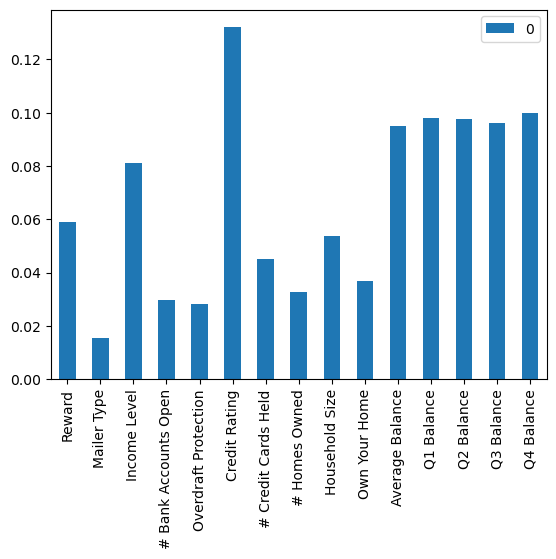

In [59]:
pd.DataFrame(model.feature_importances_, index=X_train_smote.columns).plot.bar()

In [60]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=15))

In [61]:
model = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))

Train Score: 0.730689858490566
Test Score: 0.6790878754171301
Accuracy of model on test set: 0.68
[[2374 1013]
 [ 141   68]]
              precision    recall  f1-score   support

           0       0.94      0.70      0.80      3387
           1       0.06      0.33      0.11       209

    accuracy                           0.68      3596
   macro avg       0.50      0.51      0.45      3596
weighted avg       0.89      0.68      0.76      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_sco

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

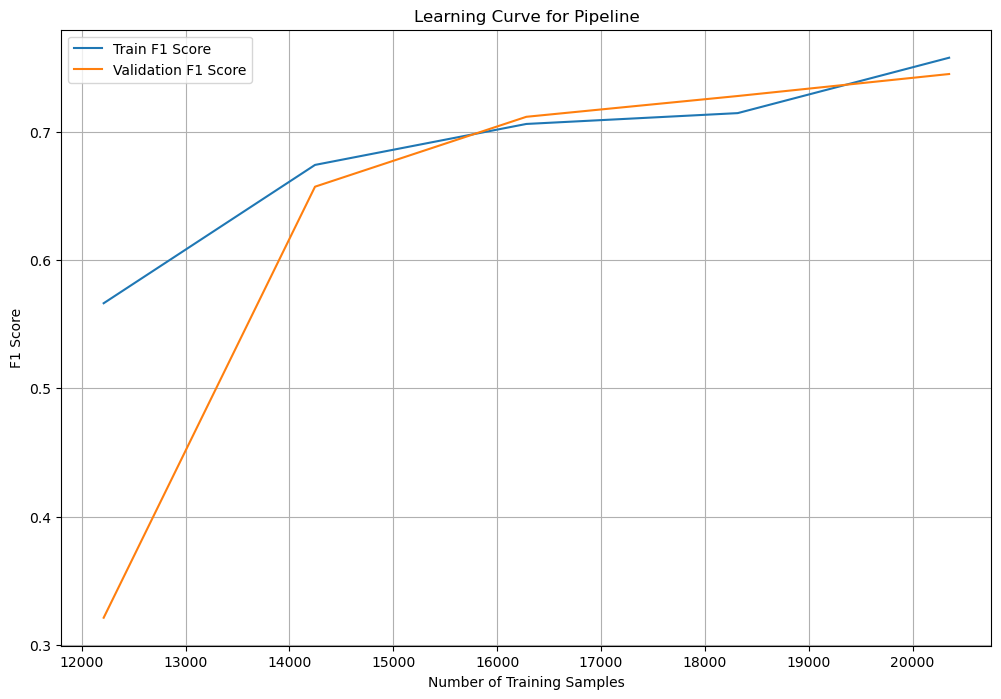

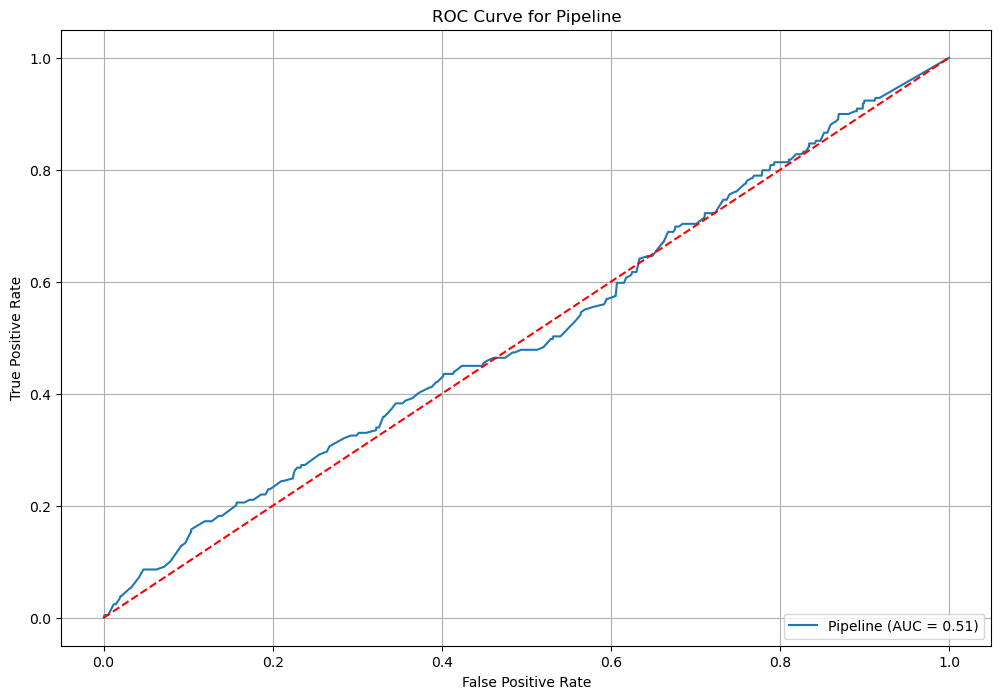

In [62]:
evaluation(model)

# Optimisation

In [63]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [64]:


# # Define the model
# model = RandomForestClassifier(random_state=42)

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [50, 100],  # Number of trees in the forest
#     'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
#     'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
#     'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider when looking for the best split
#     'bootstrap': [True, False]  # Method of sampling data when building trees
# }

# # Define GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)

# # Fit GridSearchCV
# grid_search.fit(X_train_scaled, y_train_smote)

# y_pred = grid_search.predict(X_test_scaled)
# print(classification_report(y_test, y_pred))


# # Display the best parameters
# print("Best parameters found: ", grid_search.best_params_)
# print("Best F1 Score: ", grid_search.best_score_)


In [65]:
#evaluation(grid_search.best_estimator_, X_test_scaled, y_test)

In [66]:
# Define the model
model = RandomForestClassifier(random_state=42)

# Define the hyperparameter distributions
param_dist = {
    'n_estimators': randint(100, 500),  
    'criterion': ['gini', 'entropy'],  
    'max_depth': [None, 10, 20, 30, 40, 50],  
    'min_samples_split': randint(2, 11),  
    'min_samples_leaf': randint(1, 5),  
    'max_features': ['auto', 'sqrt', 'log2', None],  
    'bootstrap': [True, False]  
}

# Define RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=4, scoring='f1', n_jobs=-1, random_state=42, verbose=2)

# Fit RandomizedSearchCV
random_search.fit(X_train_smote, y_train_smote)

# Display the best parameters
print("Best parameters found: ", random_search.best_params_)
print("Best F1 Score: ", random_search.best_score_)


Fitting 4 folds for each of 50 candidates, totalling 200 fits


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
56 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Admin\anaconda3\Lib\site-packages

Best parameters found:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 409}
Best F1 Score:  0.9293379607482646


[[3176  211]
 [ 186   23]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3387
           1       0.10      0.11      0.10       209

    accuracy                           0.89      3596
   macro avg       0.52      0.52      0.52      3596
weighted avg       0.90      0.89      0.89      3596



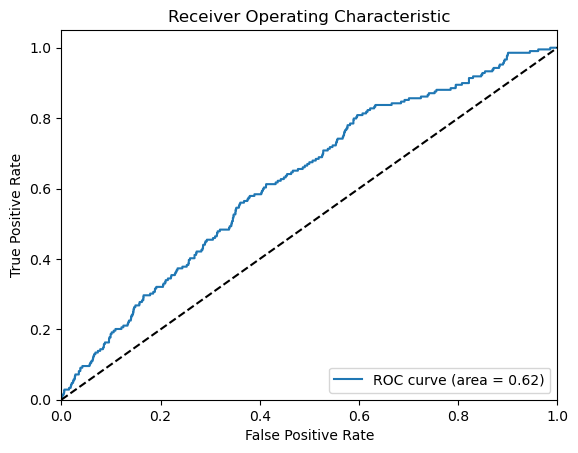

In [67]:
def evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Évaluer le meilleur modèle trouvé par RandomizedSearchCV
best_model = random_search.best_estimator_
evaluation(best_model, X_test, y_test)

Conclusion: This model simply means that if we take 10 bank customers randomly, it will be able to classify 6 of them correctly.

### Let's find the optimal threshold to decide

In [68]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

Optimal Threshold:  0.009712034773159468


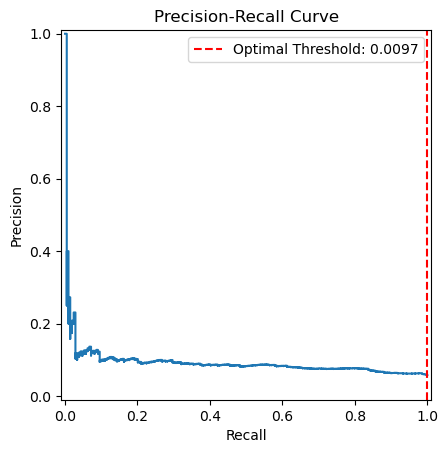

In [69]:
# Get the best model
best_model = random_search.best_estimator_

# Get the predicted probabilities
y_scores = best_model.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Find the optimal threshold
optimal_idx = np.argmax(precision + recall)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold: ", optimal_threshold)

# Plot precision-recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title('Precision-Recall Curve')
plt.axvline(x=recall[optimal_idx], color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.4f}')
plt.legend()
plt.show()

In [70]:
# Define the decision function
def decision_function(probabilities, threshold):
    return (probabilities >= threshold).astype(int)

# Make predictions on the test set using the optimal threshold
y_test_scores = best_model.predict_proba(X_test)[:, 1]
y_test_pred_optimal = decision_function(y_test_scores, optimal_threshold)

# Evaluate the new predictions

print(confusion_matrix(y_test, y_test_pred_optimal))
print(classification_report(y_test, y_test_pred_optimal))

[[  49 3338]
 [   0  209]]
              precision    recall  f1-score   support

           0       1.00      0.01      0.03      3387
           1       0.06      1.00      0.11       209

    accuracy                           0.07      3596
   macro avg       0.53      0.51      0.07      3596
weighted avg       0.95      0.07      0.03      3596



In [71]:
best_model

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=50,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=409, random_state=42)

# New Input

In [72]:
X

,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,0,0,0,1,0,0,2,1,4,0,1160.75,1669.0,877.0,1095.0,1002.0
1,0,0,2,1,0,2,2,2,5,1,147.25,39.0,106.0,78.0,366.0
2,0,1,0,2,0,2,2,1,2,1,276.50,367.0,352.0,145.0,242.0
3,0,0,2,2,0,0,1,1,4,0,1219.00,1578.0,1760.0,1119.0,419.0
4,0,0,2,1,0,2,2,1,6,1,1211.00,2140.0,1357.0,982.0,365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,1,0,0,1,0,1,1,1,5,1,167.50,136.0,65.0,71.0,398.0
17996,1,0,0,1,0,1,3,1,3,1,850.50,984.0,940.0,943.0,535.0
17997,1,0,0,1,0,1,2,1,4,0,1087.25,918.0,767.0,1170.0,1494.0
17998,1,0,2,1,0,2,4,2,2,1,1022.25,626.0,983.0,865.0,1615.0


In [73]:
#

X= np.array([['Air Miles', 'Letter', 'High', 2, 'Yes',
             'High', 2, 1, 5, 'No',
             1100.75, 1600.0, 800.0, 1000.0,1002.0]])
X

array([['Air Miles', 'Letter', 'High', '2', 'Yes', 'High', '2', '1', '5',
        'No', '1100.75', '1600.0', '800.0', '1000.0', '1002.0']],
      dtype='<U32')

In [74]:
#Apply label encoder on 

X[:, 0] = le_reward.fit_transform(X[:, 0])
X[:, 1] = le_mailerType.fit_transform(X[:, 1])
X[:, 2] = le_incomeLevel.fit_transform(X[:, 2])
X[:, 4] = le_overdraftProtection.fit_transform(X[:, 4])
X[:, 5] = le_creditRating.fit_transform(X[:, 5])
X[:, 9] = le_homeOwner.fit_transform(X[:, 9])
X = X.astype(float)
X

array([[0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 2.00000e+00, 1.00000e+00, 5.00000e+00, 0.00000e+00,
        1.10075e+03, 1.60000e+03, 8.00000e+02, 1.00000e+03, 1.00200e+03]])

In [75]:
# Make predictions on the test set using the optimal threshold
y_test_scores = best_model.predict_proba(X)[:, 1]
y_test_pred_optimal = decision_function(y_test_scores, optimal_threshold)
y_test_pred_optimal

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1])

# Export Model

In [76]:
import pickle

In [77]:
data = {'model': best_model,
       'le_reward': le_reward,
       'le_mailerType': le_mailerType,
       'le_incomeLevel': le_incomeLevel,
       'le_overdraftProtection': le_overdraftProtection,
       'le_creditRating': le_creditRating,
       'le_homeOwner': le_homeOwner}
with open('model.pkl', 'wb') as file:
    pickle.dump(data, file)

In [78]:
#Test if prediction works with saved data

with open('model.pkl', 'rb') as file:
    data = pickle.load(file)
    
best_model_loaded = data['model']
le_reward = data['le_reward']
le_mailerType = data['le_mailerType']
le_incomeLevel = data['le_incomeLevel']
le_overdraftProtection = data['le_overdraftProtection']
le_creditRating = data['le_creditRating']
le_homeOwner = data['le_homeOwner']

In [79]:
# Run prediction from loaded model

y_test_scores = best_model_loaded.predict_proba(X)[:, 1]
y_test_pred_optimal = decision_function(y_test_scores, optimal_threshold)
y_test_pred_optimal

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1])